Load the csv file...
Correct the size...
Remove junk...
Correct the abundance...
Calculating the total number of holograms analyzed...
Load the csv file...
Correct the size...
Remove junk...
Correct the abundance...
Calculating the total number of holograms analyzed...
Load the csv file...
Correct the size...
Remove junk...
Correct the abundance...
Calculating the total number of holograms analyzed...


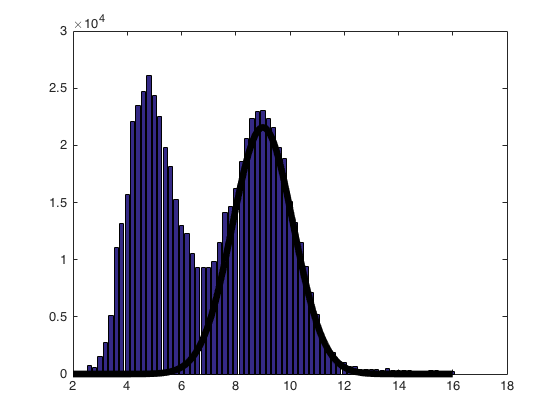

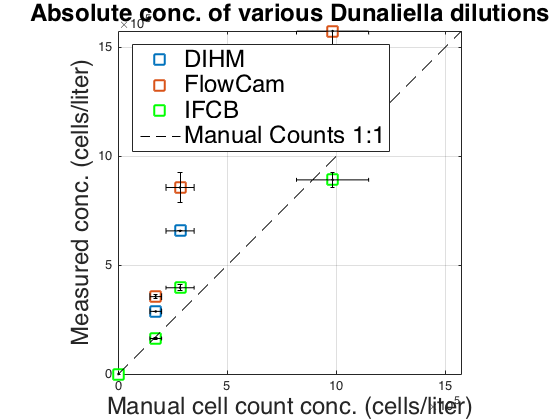

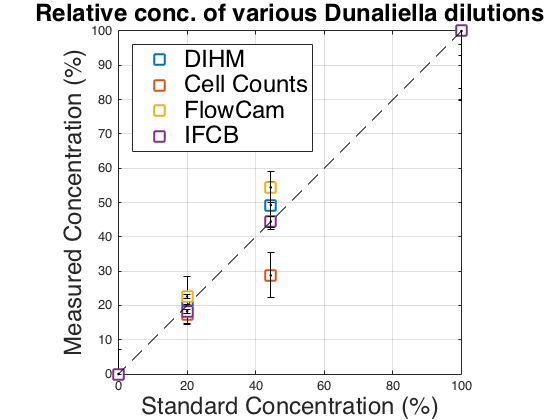

In [16]:
clear all;
close all;
clc

    %  Execute a series of funtions to correct the hologram data: load data, 
    %  calculate junk objects (re-analyze output), correct abundance, 
    %  compute concentration, correct particle sizes, and print plots and save
    %  results. noahw@uri.edu Sept 18 2017


cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis


%% 0 - Parameterization - eventually this script will become a function and these will be the inputs

    % fid_abstract = 'FLK_data_gizmo_dcm_2143images_env2.csv';
%         i = 3;
%         fid_abstract = ['output_exp',num2str(i),'_run1_5000_22000.csv'];
        dun_dir = dir(['input/dun/','*.csv']);
%         fid_csv = ['input/dun/',fid_abstract];

    % physical parameters
        dihm_volume = ((pi * 1340.^2 * 18000) - (pi * 272.^2 * 5000))/1e+15; % ((pi * 1.0639e+03.^2 * 22000) - (pi * 272.^2 * 5000))/1e+15; % 7.7068e-05 liters % 2.0456e-05; % 2.008975e+10/1e+15;%3.1284e+09/1e+15*2; %2.0090e-05; %liters; focus planes = 1000, 5000 to 15000 % will change for future analysis 5000 - 22000
        dihm_size_slope_max_fraction_decrease = 0.25; % updated sept8, 2017 %0.231; % for 5000 - 15000 || .35 for 5000 - 22000 || . dihm_size_slope = 1.3e-4;% updated from dunaliella slope from 3.515e-4; % determined empirically from 1000 stingray beads
        dihm_radial_outliers = [0.08;100]; % [m;b] ie. slope and intercept, approximate
        dihm_pixel_correct = 1; % pixel size was applied as 7 rather than 7.4 prior to 9/17/17 update, 1 = correct for DIHM pixel

    % bins
        conc_min_size = 2; % microns ESD
        conc_histogram_bins_width = .2;
        conc_histogram_bins_max = 16;
        conc_histogram_bins = conc_min_size:conc_histogram_bins_width:conc_histogram_bins_max;
        conc_min_bin_size = 50; % number of objects in bin to include in analysis

    % peaks extract function
        peaks_extract_fun = 0;
        peaks_dir = '';
        peaks_filter_number = 3; % number over which objects are considered junk
        
    % histogram fit parameters
        fit_peak = 1;
%         peak = [6352,1.473e+04,1.842e+04];
%         peak = [18420,14730,6352];
%         peak = [5.58e+04,4.41e+04,2.01e+04];
%         peak = [2.828e+04,2.32e+04,9628];
        width = .4;
        center = [9,9,9];
        range = 2:.1:16;
        
    % save vars
        save_vars = 1;


for qq = 1:3
    
    fid_csv = ['input/dun/',dun_dir(qq).name];
    
%% 1 - function to load the hologram .csv data file
    disp('Load the csv file...')
    [w_filename,w_time,w_Holofile,w_ESD,w_ESV,w_X,w_Y,w_Z] = dihm_analysis_import_csv(fid_csv);

    
%% 2 - function (optional) to extract the number of peaks from the folder structure or perform output re-analysis
    if peaks_extract_fun == 1
        disp(['Extracting the number of peaks for ','...'])
        peaks_tot_objects = length(w_X);
        [peaks_fid,peaks_tot] = dihm_analysis_peaks(peaks_dir,peaks_tot_objects);
    end
    
    % temporary fix
%         load env1_peaks_fid_no_score_again
%         load grab_scores_ifcb_env2_2145_holos
        load grab_scores_ifcb_env3_2029_holos
%         peaks_tot = numpeak;

%% 3 - correct size based on distance from source
    disp('Correct the size...')
    [w_ESD,ans_ESD_adjust_amount] = dihm_analysis_correct_size(w_ESD,w_Z,dihm_size_slope_max_fraction_decrease,dihm_pixel_correct);


%% 4 - function (optional) to remove junk based on radial outlier calculation and number of peaks max Z
    disp('Remove junk...')
%     [junk_flag] = dihm_analysis_find_junk(w_X,w_Y,w_Z,w_ESD,dihm_radial_outliers,peaks_filter_number,peaks_tot);
    [junk_flag] = dihm_analysis_find_junk_no_peaks(w_X,w_Y,w_Z,w_ESD,dihm_radial_outliers,conc_min_size); % env2 and env3 dihm_analysis_find_junk_no_peaks()
    
    ans_total_holograms = length(unique(w_filename));
    
    % remove junk from abundance and size corrections
    junk_unfiltered = length(w_X);
    w_X(junk_flag>0) = [];
    w_Y(junk_flag>0) = [];
    w_Z(junk_flag>0) = [];
    w_ESD(junk_flag>0) = [];
    w_ESV(junk_flag>0) = [];
    w_filename(junk_flag>0) = [];
    w_Holofile(junk_flag>0) = [];    
    w_time(junk_flag>0) = [];    

    %   remove filter for objects past 15000
    
    ans_junk_removed_percent = 1 - (length(w_X)/junk_unfiltered);
    
%% save the working variables
    if save_vars ==1
        save(['dun',num2str(qq)],'w_filename','w_time','w_Holofile','w_ESD','w_ESV','w_X','w_Y','w_Z')
    end
%% 5 - function to correct abundance based on scale factor matrix
    disp('Correct the abundance...')
    [ans_abundance,ans_abundance_histogram,multiply,multiply_radial,multiply_no_floor,ans_edges,ans_bin] = dihm_analysis_correct_abundance(w_X,w_Y,w_Z,w_ESD,conc_histogram_bins,dihm_radial_outliers);
    

    
%% 6 - optional, fit a curve to a peak and compute area under curve
    if fit_peak ==1
        conc_histogram_bins(1)=[];
%           peak = ans_abundance_histogram(int8(center(qq)./conc_histogram_bins_width)-int8(conc_min_size./conc_histogram_bins_width)+2); % add the dunaliella peak center here
          find_bin = center(qq)./conc_histogram_bins_width-conc_min_size./conc_histogram_bins_width;
          peak = ans_abundance_histogram(uint8(find_bin)); 
          
          [abundance_integral(qq),abundance_histogram] = dihm_analysis_fit_histogram(ans_abundance_histogram,peak,width,center(qq),range,conc_histogram_bins);
          
          pause
    end
    
%% 6 - compute concentration based on the volume and number of holograms
    disp(['Calculating the total number of holograms analyzed','...'])
    ans_total_volume_sampled = ans_total_holograms*dihm_volume; % liters
    ans_conc = ans_abundance/ans_total_volume_sampled;

%     ans_conc_uncorrected = length(w_Z)/ans_total_volume_sampled;
    
    if fit_peak ==1
        ans_conc_fit(qq,1) = abundance_integral(qq)/ans_total_volume_sampled;
    end
    
%% 7 - function that generates plots of psd, concentration. Save plots to unique subfolder ID as pngs
%     [ans_plots_corrected,ans_plots_uncorrected] = dihm_analysis_generate_plots(ans_conc,ans_abundance,ans_abundance_histogram,conc_histogram_bins,fid_abstract,w_ESD,conc_histogram_bins_max,conc_histogram_bins_width);
% 
%     fid_output = fid_abstract(1:end-4);
%     cd output
%     mkdir(fid_output)
%     cd(fid_output)
%     
%     fid_abstract_name = char(fid_abstract);
    
    cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis/
    
    save('conc_fit_dun','ans_conc_fit')

%     ylim([0 20000])
%     xlim([0 60])
    
%     save('data','ans_abundance', 'ans_abundance_histogram', 'ans_conc', 'ans_junk_removed_percent', 'ans_total_holograms', 'ans_total_volume_sampled')
%     saveas(ans_plots_uncorrected,[fid_abstract_name,'_psd_dihm.png']) % num2str(ceil(now))
    
%     cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis/
end
%% 8 - optional loop to read the culture concentrations and generate a comparision with the other gizmos
    if fit_peak == 1
        ans_conc_fit = flipud(ans_conc_fit);
        ans_conc_fit(2:4) = ans_conc_fit;
        ans_conc_fit(1) = 0;
%         ans_conc_fit_error = ans_conc_fit * .15;
        ans_conc_fit_error = ans_conc_fit * 0;
        [plot_intercomparison] = dihm_analysis_fit_histogram_intercom(ans_conc_fit,ans_conc_fit_error);
        
    end
    
%% scatter(w_Z,w_X,[],mutliply_tot), mutliply_tot = multiply .* multiply_radial;

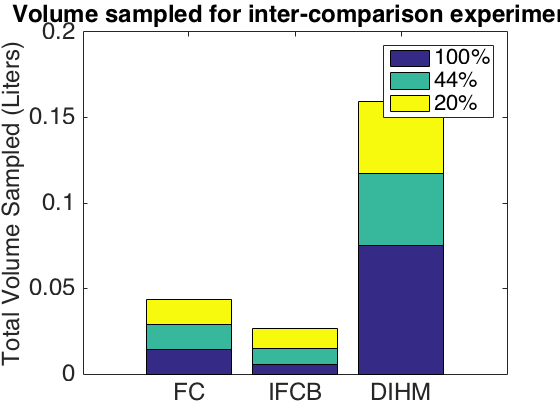

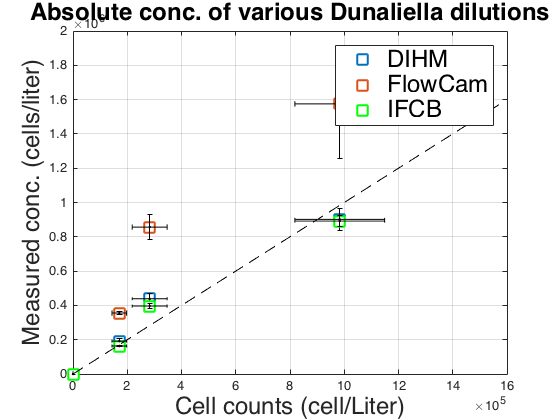

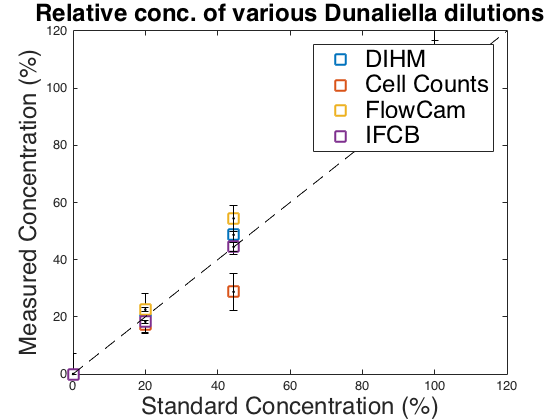

In [5]:
% FC_exp1_average_conc = 319233.607733651;
% FC_exp2_average_conc = 70982.4447380421;
% FC_exp3_average_conc = 9200.44718315833;

clear all
close all
clc

% NLW June 20, 2017 a script that plots the results of the gizmo
% intercomparison

dunc_conc_theoretical = [0;0.2,;0.444;1];

FC_conc_std     = [0;9200.44718315833;70982.4447380421;319233.607733651];     
FC_conc_avg     = [0;355363.466591723;856699.264634365;1574960.89284661]; % cells/liter
FC_normalized   = FC_conc_avg/max(FC_conc_avg);

zrinkaDun           = [0;170941;282670;983315];
zrinka_error        = [0;26976;64471;165529];
zrinka_normalized   = zrinkaDun/max(zrinkaDun);

holo_avg = [0;191780;438700;901400];
holo_error = [0;13424.6000000000;30709.0000000000;63098.0000000000];
dihm_conc_normalized = holo_avg/max(holo_avg);

a = [161001.625883810;168986.203998944;159564.166537889];
b = [379966.469630209;405711.821086790;403136.213463438];
c = [875609.327393418;868623.158468766;931038.235132332];
ifcb_modeled = [0;mean(a);mean(b);mean(c)];
ifcb_modeled_std = [0;std(a);std(b);std(c)];
ifcb_normalized = ifcb_modeled/max(ifcb_modeled);


figure(2)
% plot(dunc_conc_theoretical,dihm_conc_normalized)
% ba = 150;
% plot(dunc_conc_theoretical*100,dihm_conc_normalized*100,[ba ba ba ba],'filled','s')
di = plot(dunc_conc_theoretical*100,dihm_conc_normalized*100,'s','MarkerFaceColor','auto','MarkerSize',10);
title('Relative conc. of various Dunaliella dilutions','fontsize',18)
xlabel('Standard Concentration (%)','fontsize',18)
ylabel('Measured Concentration (%)','fontsize',18)
axis([0 120 0 120])
hold on
errorbar(dunc_conc_theoretical*100,dihm_conc_normalized*100,[7 7 7 7],'.k')

% zrinkaDun = [0;170941;282670;983315];
% zrinka_error = [0 26976 64471 165529];
zi = plot(dunc_conc_theoretical*100,zrinkaDun/max(zrinkaDun)*100,'s','MarkerFaceColor','auto','MarkerSize',10);
errorbar(dunc_conc_theoretical*100,zrinkaDun/max(zrinkaDun)*100,zrinka_error/max(zrinkaDun)*100,'.k')

fc = plot(dunc_conc_theoretical*100,FC_normalized*100,'s','MarkerFaceColor','auto','MarkerSize',10);
errorbar(dunc_conc_theoretical*100,FC_conc_avg/max(FC_conc_avg)*100,FC_conc_std/max(FC_conc_avg)*100,'.k')

ifcb = plot(dunc_conc_theoretical*100,ifcb_normalized*100,'s','MarkerFaceColor','auto','MarkerSize',10);
errorbar(dunc_conc_theoretical*100,ifcb_modeled/max(ifcb_modeled)*100,ifcb_modeled_std/max(ifcb_modeled)*100,'.k')


lgd = legend([di zi fc ifcb],{'DIHM','Cell Counts','FlowCam', 'IFCB'});
lgd.FontSize = 18;


plot([0 1.2]*100,[0 1.2]*100,'k--')
hold off





figure(3)
% plot(dunc_conc_theoretical,dihm_conc_normalized)
% ba = 150;
% plot(dunc_conc_theoretical*100,dihm_conc_normalized*100,[ba ba ba ba],'filled','s')
di = plot(zrinkaDun,holo_avg,'square','MarkerFaceColor','auto','MarkerSize',10);
title('Absolute conc. of various Dunaliella dilutions','fontsize',18)
xlabel('Cell counts (cell/Liter)','fontsize',18)
ylabel('Measured conc. (cells/liter)','fontsize',18)
axis([0 16e5 0 20e5])

hold on
errorbar(zrinkaDun,holo_avg,holo_error,'.k')

% zrinkaDun = [0;170941;282670;983315];
% zrinka_error = [0 26976 64471 165529];
zi = plot(zrinkaDun,FC_conc_avg,'s','MarkerFaceColor','auto','MarkerSize',10);
errorbar(zrinkaDun, FC_conc_avg,FC_conc_std,'.k')

ifcb2 = plot(zrinkaDun,ifcb_modeled,'s','MarkerFaceColor','auto','MarkerSize',10,'MarkerEdgeColor','g');
errorbar(zrinkaDun, ifcb_modeled,ifcb_modeled_std,'.k')

% manualcount = plot(zrinkaDun,zrinkaDun,'s','MarkerFaceColor','auto','MarkerSize',10,'MarkerEdgeColor','c');
% errorbar(zrinkaDun, zrinkaDun,zrinka_error,'.k')


lgd = legend([di zi ifcb2],{'DIHM','FlowCam', 'IFCB'});
lgd.FontSize = 18;

plot([0 max(FC_conc_avg)],[0 max(FC_conc_avg)],'k--')

herrorbar(zrinkaDun,holo_avg,zrinka_error,'.k')
herrorbar(zrinkaDun,FC_conc_avg,zrinka_error,'.k')
herrorbar(zrinkaDun,ifcb_modeled,zrinka_error,'.k')
grid
hold off


%%  volume comparisons
volume_comparisons = [0.0144768000000000,0.00561600000000000,0.0753394480000000;0.0144975000000000,0.00912950000000000,0.0420984480000000;0.0144729000000000,0.0118239000000000,0.0420984480000000];
% volume_comparisons_time_norm = [0.000438690909100000,9.36000000000000e-05,0.0125565746700000;0.000439318181800000,0.000152158333300000,0.00701640800000000;0.000438572727300000,0.000197065000000000,0.00701640800000000];
figure(6)
bar(volume_comparisons','stacked','DisplayName','new')
legend('100%','44%','20%')
set(gca,'XTickLabel',{'FC','IFCB','DIHM'},'fontsize',18)
ylabel('Total Volume Sampled (Liters)','fontsize',18)
title('Volume sampled for inter-comparison experiment','fontsize',18)


% figures for ocb 2017 conference


% 
% 
% figure(4)
% scatter(zrinkaDun,dihm_concentration,'filled','s')
% title(['DIHM v. Manual counts concentration, scaling coefficient ',num2str(1/scale_factor)],'fontsize',14)
% xlabel('Manual Counts  conc. (cells/L)','fontsize',18)
% ylabel('DIHM conc. (cells/L)','fontsize',18)
% axis([0 1.2*max(zrinkaDun) 0 1.2*max(dihm_concentration)])
% 
% hold on
% plot([0 max(dihm_concentration)],[0 max(dihm_concentration)],'k--')
% herrorbar(zrinkaDun,dihm_concentration,zrinka_error,'.k')
% errorbar(zrinkaDun,dihm_concentration,0.07*dihm_concentration,'.k')

Load the csv file...
Correct the size...
Remove junk...
Correct the abundance...
Calculating the total number of holograms analyzed...
Load the csv file...
Correct the size...
Remove junk...
Correct the abundance...
Calculating the total number of holograms analyzed...
Load the csv file...
Correct the size...
Remove junk...
Correct the abundance...
Calculating the total number of holograms analyzed...


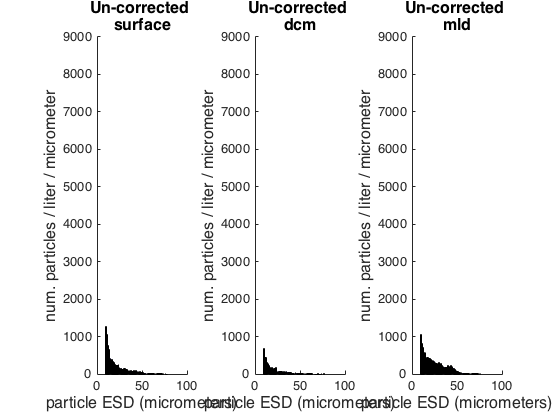

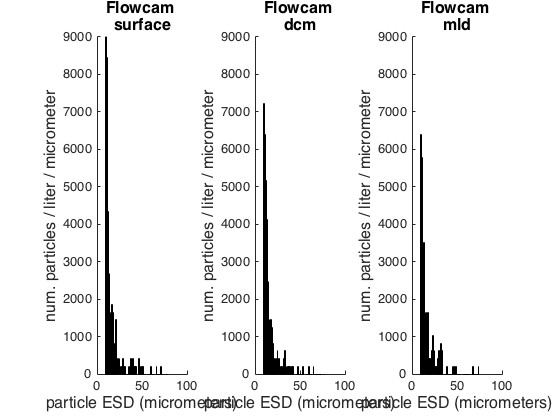

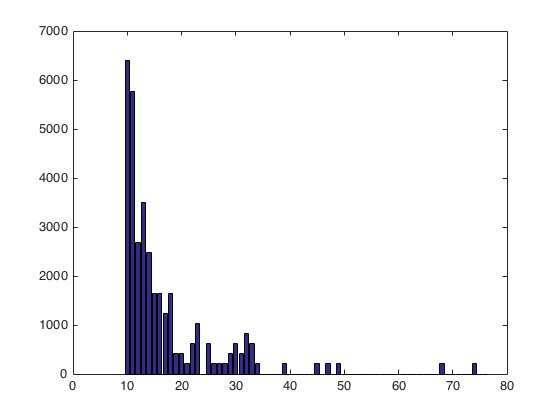

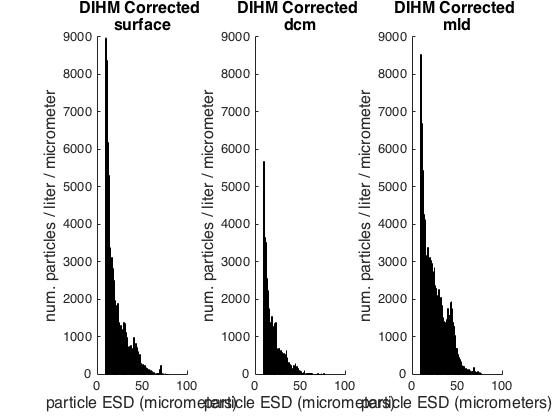

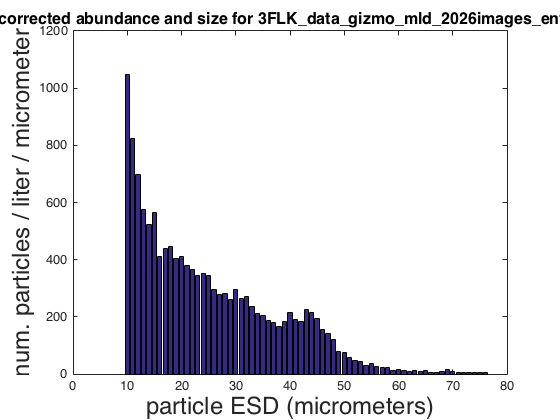

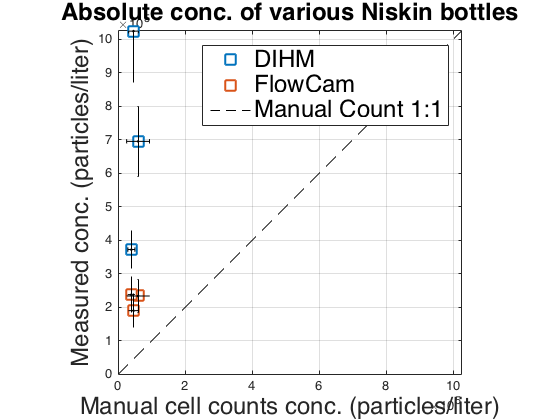

In [9]:
clear all;
close all;
clc

cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis


    %  Execute a series of funtions to correct the hologram data: load data, 
    %  calculate junk objects (re-analyze output), correct abundance, 
    %  compute concentration, correct particle sizes, and print plots and save
    %  results. noahw@uri.edu Sept 18 2017


%% 0 - Parameterization - eventually this script will become a function and these will be the inputs

    % fid_abstract = 'FLK_data_gizmo_dcm_2143images_env2.csv';
%         i = 3;
%         fid_abstract = ['output_exp',num2str(i),'_run1_5000_22000.csv'];
        dun_dir = dir(['input/niskin/','*.csv']);
        abstract_name = {'surface';'dcm';'mld'};

    % physical parameters
        dihm_volume = ((pi * 1.0639e+03.^2 * 15000) - (pi * 272.^2 * 5000))/1e+15; % 7.7068e-05 liters % 2.0456e-05; % 2.008975e+10/1e+15;%3.1284e+09/1e+15*2; %2.0090e-05; %liters; focus planes = 1000, 5000 to 15000 % will change for future analysis 5000 - 22000
        dihm_size_slope_max_fraction_decrease = 0.31; % updated sept8, 2017 %0.231; % for 5000 - 15000 || .35 for 5000 - 22000 || . dihm_size_slope = 1.3e-4;% updated from dunaliella slope from 3.515e-4; % determined empirically from 1000 stingray beads
        dihm_radial_outliers = [0.08;100]; % [m;b] ie. slope and intercept, approximate
        dihm_pixel_correct = 1; % pixel size was applied as 7 rather than 7.4 prior to 9/17/17 update, 1 = correct for DIHM pixel

    % bins
        conc_min_size = 10; % microns ESD
        conc_histogram_bins_width = 1;
        conc_histogram_bins_max = 80;
        conc_histogram_bins = conc_min_size:conc_histogram_bins_width:conc_histogram_bins_max;
%         conc_min_bin_size = 50; % number of objects in bin to include in analysis

    % peaks extract function
        peaks_extract_fun = 0;
        peaks_dir = '';
        peaks_filter_number = 3; % number over which objects are considered junk
        
    % histogram fit parameters
        fit_peak = 0;
        width = .4;
        center = [8.6,9,9];
        range = 2:.1:16;
        
    % save vars
        save_vars = 0;


for qq = 1:3
    
    fid_csv = ['input/niskin/',dun_dir(qq).name];
    fid_abstract{qq,1} = dun_dir(qq).name;
    
%% 1 - load the hologram .csv data file
    disp('Load the csv file...')
    [w_filename,w_time,w_Holofile,w_ESD,w_ESV,w_X,w_Y,w_Z] = dihm_analysis_import_csv(fid_csv);

    
%% 2 - function (optional) to extract the number of peaks from the folder structure or perform output re-analysis
    if peaks_extract_fun == 1
        disp(['Extracting the number of peaks for ','...'])
        peaks_tot_objects = length(w_X);
        [peaks_fid,peaks_tot] = dihm_analysis_peaks(peaks_dir,peaks_tot_objects);
    end
    
    % temporary fix
%         load env1_peaks_fid_no_score_again
%         load grab_scores_ifcb_env2_2145_holos
        load grab_scores_ifcb_env3_2029_holos
%         peaks_tot = numpeak;

%% 3 - correct size based on distance from source
    disp('Correct the size...')
    [w_ESD,ans_ESD_adjust_amount] = dihm_analysis_correct_size(w_ESD,w_Z,dihm_size_slope_max_fraction_decrease,dihm_pixel_correct);


%% 4 - function (optional) to remove junk based on radial outlier calculation and number of peaks max Z
    disp('Remove junk...')
%     [junk_flag] = dihm_analysis_find_junk(w_X,w_Y,w_Z,w_ESD,dihm_radial_outliers,peaks_filter_number,peaks_tot);
    [junk_flag] = dihm_analysis_find_junk_no_peaks(w_X,w_Y,w_Z,w_ESD,dihm_radial_outliers,conc_min_size); % env2 and env3 dihm_analysis_find_junk_no_peaks()
    
    ans_total_holograms = length(unique(w_filename));
    
    % remove junk from abundance and size corrections
    junk_unfiltered = length(w_X);
    w_X(junk_flag>0) = [];
    w_Y(junk_flag>0) = [];
    w_Z(junk_flag>0) = [];
    w_ESD(junk_flag>0) = [];
    w_ESV(junk_flag>0) = [];
    w_filename(junk_flag>0) = [];
    w_Holofile(junk_flag>0) = [];    
    w_time(junk_flag>0) = [];    

    %   remove filter for objects past 15000
    
    ans_junk_removed_percent = 1 - (length(w_X)/junk_unfiltered);
    
%% save the working variables
    if save_vars ==1
        save(['dun',num2str(qq)],'w_filename','w_time','w_Holofile','w_ESD','w_ESV','w_X','w_Y','w_Z')
    end
%% 5 - function to correct abundance based on scale factor matrix - updated to be the radial/spherical wave approximation calculation
    disp('Correct the abundance...')
    [ans_abundance,ans_abundance_histogram,multiply,multiply_radial] = dihm_analysis_correct_abundance(w_X,w_Y,w_Z,w_ESD,conc_histogram_bins,dihm_radial_outliers);
    

    
%% 6 - optional, fit a curve to a peak and compute area under curve
    if fit_peak ==1
        conc_histogram_bins(1)=[];
          peak = ans_abundance_histogram(32); % add the dunaliella peak center here
          [abundance_integral(qq),abundance_histogram] = dihm_analysis_fit_histogram(ans_abundance_histogram,peak,width,center(qq),range,conc_histogram_bins);
          
%           pause
    end
    
%% 6 - compute concentration based on the volume and number of holograms
    disp(['Calculating the total number of holograms analyzed','...'])
    ans_total_volume_sampled = ans_total_holograms*dihm_volume; % liters
    ans_conc_dihm(qq,1) = ans_abundance/ans_total_volume_sampled;
    ans_conc_dihm_uncor(qq,1) = length(w_ESD)/ans_total_volume_sampled;
%     ans_conc_uncorrected = length(w_Z)/ans_total_volume_sampled;
    
    if fit_peak ==1
        ans_conc_fit(qq,1) = abundance_integral(qq)/ans_total_volume_sampled;
    end
    
%% 7 - function that generates plots of psd, concentration. Save plots to unique subfolder ID as pngs
    conc_histogram_bins(end) = []; % this move is total garbage. fix this line
    [ans_plots_corrected(qq,1),ans_plots_uncorrected(qq,1)] = dihm_analysis_generate_plots_niskin_nolog(ans_conc_dihm(qq),ans_abundance,ans_abundance_histogram,conc_histogram_bins,char(fid_abstract{qq}),w_ESD,conc_histogram_bins_max,conc_histogram_bins_width);
% 	ylim([0 1400]) 
    figure(4)
    hu = subplot(1,3,qq);
    copyobj(ans_plots_corrected(qq),hu)
        xlabel('particle ESD (micrometers)','fontsize',12)
        ylabel('num. particles / liter / micrometer','fontsize',12)
        t = title(['DIHM Corrected ',abstract_name(qq)],'fontsize',12);
        set(t, 'Interpreter', 'none')
%         xlim([0,conc_histogram_bins_max])
%         ylim([0 4500])
        plim = [0 9000];
        ylim(plim)
% 
        
        [ans_plots_fc(qq,1),ans_conc_fc(qq,1),fileproc{qq,1}] = dihm_analysis_niskin_flowcam(conc_histogram_bins,qq);
            figure(6)
            huu = subplot(1,3,qq);
            copyobj(ans_plots_fc(qq),huu)
                    xlabel('particle ESD (micrometers)','fontsize',12)
                    ylabel('num. particles / liter / micrometer','fontsize',12)
                            t = title(['Flowcam ',abstract_name(qq)],'fontsize',12);
                            set(t, 'Interpreter', 'none')
                    ylim(plim)

    figure(5)
    hus = subplot(1,3,qq);
    copyobj(ans_plots_uncorrected(qq),hus)
        xlabel('particle ESD (micrometers)','fontsize',12)
        ylabel('num. particles / liter / micrometer','fontsize',12)
        t = title(['Un-corrected ',abstract_name(qq)],'fontsize',12);
        set(t, 'Interpreter', 'none')
%         xlim([0,conc_histogram_bins_max])
%         ylim([0 1400])
        ylim(plim)
    
%     fid_output = fid_abstract(1:end-4);
%     cd output
%     mkdir(fid_output)
%     cd(fid_output)
%     
%     fid_abstract_name = char(fid_abstract);
    
%     cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis/
    
%     save('conc_fit_dun','ans_conc_fit')

%     ylim([0 20000])
%     xlim([0 60])
    
%     save('data','ans_abundance', 'ans_abundance_histogram', 'ans_conc', 'ans_junk_removed_percent', 'ans_total_holograms', 'ans_total_volume_sampled')
%     saveas(ans_plots_uncorrected,[fid_abstract_name,'_psd_dihm.png']) % num2str(ceil(now))
    
    cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis/
%     pause
end
%% 8 - optional loop to read the culture concentrations and generate a comparision with the other gizmos

%         ans_conc_fit = flipud(ans_conc_fit);
%         ans_conc_fit(2:4) = ans_conc_fit;
%         ans_conc_fit(1) = 0;
        ans_conc_fit_error = ans_conc_dihm * .15;
        [plot_intercomparison] = dihm_analysis_fit_histogram_intercom_niskin(ans_conc_dihm,ans_conc_fit_error,ans_conc_fc);
        
    
%% scatter(w_Z,w_X,[],mutliply_tot), mutliply_tot = multiply .* multiply_radial;

%% plot all dihm figures as subplots
    mutliply_tot = multiply .* multiply_radial;

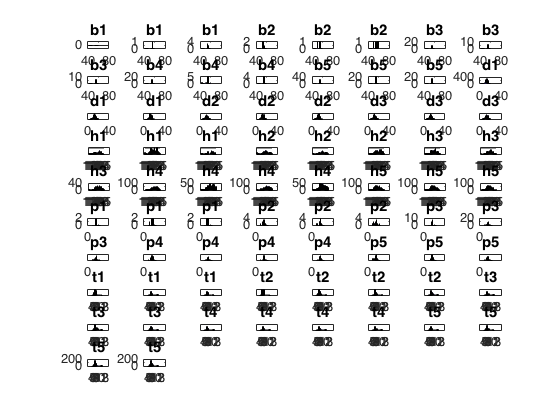

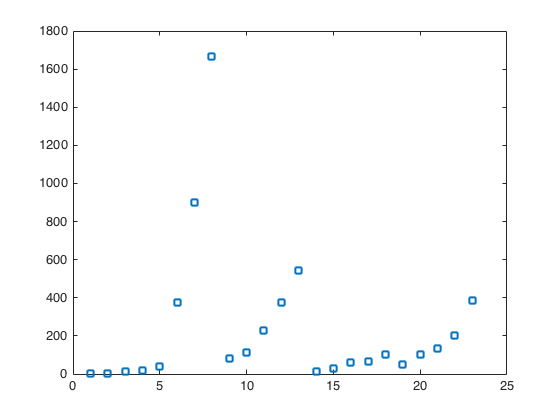

In [7]:
clear all
close all
clc

cd /Users/noahwalcutt/Documents/MatLab/gizmoPaper/fcAnalysis


% a script for reading, fitting a curve to, and computing concentation of the ifcb data: dunaliella, heterosigma, beads. 

%% generate the list of target files
dir_in = '/Users/noahwalcutt/Documents/MatLab/gizmoPaper/fcAnalysis/input/';
% hdr_dir = '/Users/noahwalcutt/Documents/MatLab/gizmoPaper/ifcbAnalysis/hdr/';
sampleTags = {'b','d','h','p','t'};

dir_input = dir(dir_in);
c = {dir_input.name};
keep = cellfun(@(s) ~any(s == '.'), c);
dir_input = dir_input(keep);
dir_input_csv_fo = strcat(dir_in,{dir_input.name},'/')';
dir_input_name = {dir_input.name};

i=1;
j=1;

%% histogram fit parameters

    conc_min_size = [repmat(40,1,15),...% b
                    repmat(0,1,9),...% d
                    repmat(10,1,16),... % h
                    repmat(20,1,16),... % p
                    repmat(3,1,18)];%,... % t
%                     repmat(0,1,15)]; % p, microns ESD
    conc_histogram_bins_width = [repmat(1,1,15),...% b
                    repmat(1,1,9),...% d
                    repmat(1,1,16),... % h
                    repmat(1,1,16),... % p
                    repmat(1,1,18)];%,... % t
%                     repmat(0,1,15)]; % p, microns ESD
    conc_histogram_bins_max = [repmat(60,1,15),...% b
                    repmat(20,1,9),...% d
                    repmat(25,1,16),... % h
                    repmat(60,1,16),... % p
                    repmat(13,1,18)];%,... % t
%                     repmat(0,1,15)]; % p, microns ESD

    fit_peaks = [337,360,367,727,886,975,1758,1730,1617,1,1,1,1,1,1,...% b
                337,360,367,727,886,975,1758,1730,1617,...% d
                5,9,8,13,23,16,29,20,26,53,48,60,46,63,64,65,...% h
                2,2,2,31,43,67,57,264,222,235,154,372,106,160,162,111,... % p
                20,25,22,1,39,34,28,51,48,62,106,104,105,51,105,81,143,167]; % t
%                 11,11,11,11,11,11,11,11,11,11,11,11,11,11,11]; % p, no floor multiplier
    fit_width = [repmat(0.15,1,15),...% b
                    repmat(0.15,1,9),...% d
                    repmat(0.2,1,16),... % h
                    repmat(0.2,1,16),... % p
                    repmat(0.7,1,18)];%,... % t
%                     repmat(0,1,15)]; % p, microns ESD
    fit_center = [repmat(12,1,15),...% b
                    repmat(12,1,9),...% d
                    repmat(19,1,16),... % h
                    repmat(39,1,16),... % p
                    repmat(7,1,18)];%,... % t
%                     repmat(0,1,15)]; % p, microns ESD


%% generate the .csv and .hdr filenames
for qq = 1:length(dir_input)
    working_dir = strcat(dir_in,{dir_input(qq).name},'/')';
    working_fid = dir(char(working_dir));
%     working_fid = working_fid(4:end);
    working_names = {working_fid.name};
    for y = 1:length(working_names)
        temp = char(working_names(y));
        temp_hdr = temp(1:end-11);
        tf = strcmp(temp(1),'.');
        if tf == 0
            tf2 = strcmp(temp(end-2:end),'txt');
            if tf2 == 0
            fid_csv(i,1) = strcat(working_dir,working_names(y));
%             fid_hdr{i,1} = strcat(hdr_dir,temp_hdr,'.hdr');
            fc(i,:).fid_sample = dir_input_name(qq);
            i = i+1;
            end
            
            if tf2 == 1
            fid_txt(j,1) = strcat(working_dir,working_names(y));
%             fid_hdr{i,1} = strcat(hdr_dir,temp_hdr,'.hdr');
%             fc(i,:).fid_sample = dir_input_name(qq);
            j = j+1;
            end
        end
    end
    
end




%% loop through each subdirectory, read the file, plot the ESD in 1 micron increments, fit a curve to the peak
for uu = 1:length(fid_csv)
    % read the csv file
    try
             [ParticleID,AreaABD,AreaFilled,AspectRatio,AverageBlue,AverageGreen,AverageRed,CalibrationFactor,...
                 CalibrationImage,Camera,CaptureX,CaptureY,Ch1Area,Ch1Peak,Ch1Width,Ch2Area,Ch2Peak,Ch2Width,...
                 Ch2Ch1Ratio,CircleFit,Circularity,CircularityHu,Compactness,ConvexPerimeter,Convexity,Date,...
                 DiameterABD,DiameterESD,EdgeGradient,Elongation,FeretAngleMax,FeretAngleMin,FiberCurl,FiberStraightness,...
                 FilterScore,GeodesicAspectRatio,GeodesicLength,GeodesicThickness,ImageFile,ImageHeight,ImageWidth,ImageX,ImageY,...
                 Intensity,Length,ParticlesPerChain,Perimeter,RatioBlueGreen,RatioRedBlue,RatioRedGreen,Roughness,ScatterArea,ScatterPeak,...
                 ScatterWidth,SigmaIntensity,SourceImage,SumIntensity,Symmetry,Time,Timestamp,Transparency,VolumeABD,VolumeESD,Width] = importfileFlowCam2(char( fid_csv(uu)));

        fc(uu,:).esd = DiameterESD;
        fc(uu,:).esd_length = length(DiameterESD);
    catch
                     [ParticleID,AreaABD,AreaFilled,AspectRatio,AverageBlue,AverageGreen,AverageRed,CalibrationFactor,...
                 CalibrationImage,Camera,CaptureX,CaptureY,Ch1Area,Ch1Peak,Ch1Width,Ch2Area,Ch2Peak,Ch2Width,...
                 Ch2Ch1Ratio,CircleFit,Circularity,CircularityHu,Compactness,ConvexPerimeter,Convexity,Date,...
                 DiameterABD,DiameterESD,EdgeGradient,Elongation,FeretAngleMax,FeretAngleMin,FiberCurl,FiberStraightness,...
                 FilterScore,GeodesicAspectRatio,GeodesicLength,GeodesicThickness,ImageFile,ImageHeight,ImageWidth,ImageX,ImageY,...
                 Intensity,Length,ParticlesPerChain,Perimeter,RatioBlueGreen,RatioRedBlue,RatioRedGreen,Roughness,ScatterArea,ScatterPeak,...
                 ScatterWidth,SigmaIntensity,SourceImage,SumIntensity,Symmetry,Time,Timestamp,Transparency,VolumeABD,VolumeESD,Width] = importfileFlowCam(char( fid_csv(uu)));

        fc(uu,:).esd = DiameterESD;
        fc(uu,:).esd_length = length(DiameterESD);
    end
    
        conc_histogram_bins = conc_min_size(uu):conc_histogram_bins_width(uu):conc_histogram_bins_max(uu);
        fc(uu,:).histogram = histcounts(fc(uu,:).esd, conc_histogram_bins);
        conc_xaxis = conc_histogram_bins;
        conc_xaxis(1) = [];
        
    % get volume from the corresponding .hdr file
              textBlock = importfileFlowCam_summarytxt(char( fid_txt(uu) ));

              temp = char(textBlock(5));
              fc(uu).volImaged = str2double(temp(22:27));
              
              temp = char(textBlock(3));
              fc(uu).volAsp = str2double(temp(26:31));
              
              temp = char(textBlock(4));
              fc(uu).volPro = str2double(temp(26:31));
%               
%               
%               fc(i).quickConc = length(fc(i,:).ESD) ./ fc(i).volPro;
% 
%               temp = char(textBlock(14));
%               fc(i).startTime = datenum(temp(9:end), 'yyyy-mm-dd HH:MM:SS');
% 
%               temp = char(textBlock(15));
%               fc(i).endTime = datenum(temp(7:end), 'yyyy-mm-dd HH:MM:SS');
%         
    % plot the histogram of esds, fit a gaussian mod 11/23/17 subplot
%           [fc(uu,:).abundance_integral(:),fc(uu,:).abundance_histogram(:,:)] = ...
%               fit_histogram(  fc(uu,:).histogram, ...
%               fit_peaks(uu),fit_width(uu),fit_center(uu),conc_histogram_bins,conc_xaxis,char(fc(uu,:).fid_sample));
%           
          [fc(uu,:).abundance_integral(:),fc(uu,:).abundance_histogram(:,:),fc(uu,:).abundance_sum(:)] = ...
                fit_histogram_subplot(  fc(uu,:).histogram, ...
                fit_peaks(uu),fit_width(uu),fit_center(uu),conc_histogram_bins,conc_xaxis,char(fc(uu,:).fid_sample),uu);
          
    % compute concentration 11/24/18 update
%           fc(uu,:).conc_cells_ml = fc(uu,:).abundance_integral(:) ./ fc(uu,:).volPro;
          fc(uu,:).conc_cells_ml = fc(uu,:).abundance_sum(:) ./ fc(uu,:).volPro;
          
%           pause
          clear conc_histogram_bins
end


%% Compute mean and std, comute conc/store all the vars 
    [finalFC] = fcAnalysisConsolidate(sampleTags,[fc.fid_sample],[fc.conc_cells_ml],dir_input_name);


%% Plot the result with error bars
figure(3)
plot([finalFC.meanConcFC],'s')

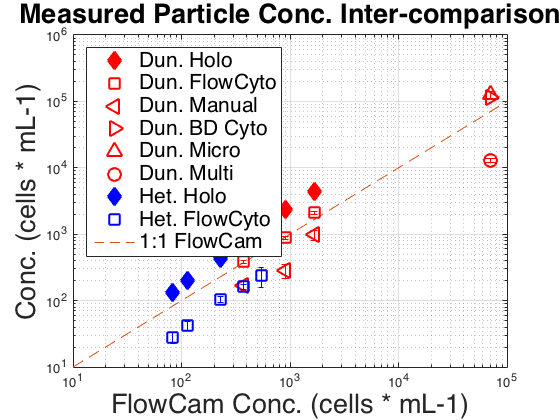

In [4]:
clear all 
close all
clc

cd /Users/noahwalcutt/Documents/MatLab/gizmoPaper/gizmoAnalysis

% a script for loading the results of the gizmo concentration, finding the
% index of the corresponding samples, plotting the concentration against a
% given variable, color-coding the legend

% load the vars for dihm, ifcb, fc, manual, cc. dump each file in common
% folder
% load organismFC
load organismIFCB
% load organismFC_sum
load organismFC_sum_beads_Dec1
% load organismIFCB_sum
load organismDIHM

finalDIHM2 = struct('tag',{finalDIHM.sample},'meanConcDIHM',{finalDIHM.ans_conc_fit},'stdDIHM',1,'instrument','dihm')';

% function to combine all results into one structure
% final = [finalFC;finalIFCB;finalDIHM2];
listTags = [[finalDIHM2.tag]';[{finalFC.tag}]';[{finalIFCB.tag}]'];
finalTag = unique(listTags);


for i = 1:length(finalTag)
   temp = finalTag(i);
   
   temp2FC = [finalFC.meanConcFC];
   temp2IFCB = [finalIFCB.meanConcIFCB];
   temp2DIHM = [finalDIHM2.meanConcDIHM];
   
   temp2FCstd = [finalFC.stdFC];
   temp2IFCBstd = [finalIFCB.stdIFCB];
   temp2DIHMstd = [finalDIHM2.stdDIHM];
   
   tagIndexFC = strfind({finalFC.tag}, char(temp));
   tagIndexFC = find(~cellfun(@isempty,tagIndexFC));
   
   tagIndexIFCB = strfind({finalIFCB.tag}, char(temp));
   tagIndexIFCB = find(~cellfun(@isempty,tagIndexIFCB));
   
   tagIndexDIHM = strfind([finalDIHM2.tag], char(temp));
   tagIndexDIHM = find(~cellfun(@isempty,tagIndexDIHM));

   % conc
   final(i).tag = temp;
   final(i).concFC = temp2FC(tagIndexFC);
   final(i).concIFCB = temp2IFCB(tagIndexIFCB);
   final(i).concDIHM = temp2DIHM(tagIndexDIHM) ./ 1000;
   
   % std
   final(i).stdFC = temp2FCstd(tagIndexFC);
   final(i).stdIFCB = temp2IFCBstd(tagIndexIFCB);
   final(i).stdDIHM = temp2DIHMstd(tagIndexDIHM);
   
end

% zrinka
final(6).concZrinka           = 170941 ./1000;
final(7).concZrinka           = 282670 ./1000;
final(8).concZrinka           = 983315 ./1000;
final(6).stdZrinka        = 26976 ./1000;
final(7).stdZrinka        = 64471 ./1000;
final(8).stdZrinka        = 165529 ./1000;

% SMD results
final(25).tag = 'dunTer';

final(25).concFC = 70739;
final(25).concBD = 114198;
final(25).concMicro = 125400;
final(25).concMulti = 12834;

final(25).stdFC = 4743;
final(25).stdBD = 16575;
final(25).stdMicro = 13550;
final(25).stdMulti = 893;

% cell array to choose what samples to show in the graph, using sampleTag
paramVars = {'d','h'};

% choose what instrument to show on the x-axis
paramX = {'ifcb'};

% assign colors to each instrument
paramColor = {'r','b','m'};

% assign shape to each sample type
paramShape = {'square','diamond','<','>','^','o'};

si = 10; %marker size

figure(1);
set(gcf,'WindowStyle','docked')
dunFC = loglog([final(6:8).concFC],[final(6:8).concIFCB],'Marker',char(paramShape(1)),'Color',char(paramColor(1)),'MarkerSize',si,'LineStyle','none');
hold on
dunDIHM = loglog([final(6:8).concFC],[final(6:8).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(1)),'MarkerSize',si,'LineStyle','none','MarkerFaceColor',char(paramColor(1)));
dunZrinka = loglog([final(6:8).concFC],[final(6:8).concZrinka],'Marker',char(paramShape(3)),'Color',char(paramColor(1)),'MarkerSize',si,'LineStyle','none');
hetFC = loglog([final(9:13).concFC],[final(9:13).concIFCB],'Marker',char(paramShape(1)),'Color',char(paramColor(2)),'MarkerSize',si,'LineStyle','none');
hetDIHM = loglog([final(9:13).concFC],[final(9:13).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(2)),'MarkerSize',si,'LineStyle','none','MarkerFaceColor',char(paramColor(2)));
% beadDIHM = loglog([final(1:5).concFC],[final(1:5).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(3)),'LineStyle','none','MarkerFaceColor',char(paramColor(3)));

dunTerBD = loglog([final(25).concFC],[final(25).concBD],'Marker',char(paramShape(4)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
dunTerMicro = loglog([final(25).concFC],[final(25).concMicro],'Marker',char(paramShape(5)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
dunTerMulti = loglog([final(25).concFC],[final(25).concMulti],'Marker',char(paramShape(6)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);


x=logspace(1,5);
y=x;
logg = loglog(x,y,'--');




errdunFC = errorbar([final(6:8).concFC],[final(6:8).concIFCB],[final(6:8).stdIFCB],    'Marker',char(paramShape(1)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errdunDIHM = errorbar([final(6:8).concFC],[final(6:8).concDIHM],[final(6:8).stdDIHM],    'Marker',char(paramShape(2)),'Color',char(paramColor(1)),'LineStyle','none','MarkerFaceColor',char(paramColor(1)),'MarkerSize',si);
errdunZrinka = errorbar([final(6:8).concFC],[final(6:8).concZrinka],[final(6:8).stdZrinka],    'Marker',char(paramShape(3)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errhetFC = errorbar([final(9:13).concFC],[final(9:13).concIFCB],[final(9:13).stdIFCB],    'Marker',char(paramShape(1)),'Color',char(paramColor(2)),'LineStyle','none','MarkerSize',si);
errhetDIHM = errorbar([final(9:13).concFC],[final(9:13).concDIHM],[final(9:13).stdDIHM],    'Marker',char(paramShape(2)),'Color',char(paramColor(2)),'LineStyle','none','MarkerFaceColor',char(paramColor(2)),'MarkerSize',si);
% errbeadDIHM = errorbar([final(1:5).concFC],[final(1:5).concDIHM],[final(1:5).stdDIHM],    'Marker',char(paramShape(2)),'Color',char(paramColor(3)),'LineStyle','none','MarkerFaceColor',char(paramColor(3)));

% errdunTerBD = errorbar([final(25).concFC],[final(25).concBD],[final(25).concBD],'Marker',char(paramShape(4)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errdunTerMicro = errorbar([final(25).concFC],[final(25).concMicro],[final(25).stdMicro],'Marker',char(paramShape(5)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errdunTerMulti = errorbar([final(25).concFC],[final(25).concMulti],[final(25).stdMulti],'Marker',char(paramShape(6)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errorbarlogyy;

% herrdunFC = herrorbar([final(6:8).concFC],[final(6:8).concIFCB],[final(6:8).stdIFCB],'s');
% % herrdunDIHM = herrorbar([final(6:8).concFC],[final(6:8).concDIHM],[final(6:8).stdIFCB]);
% herrdunZrinka = herrorbar([final(6:8).concFC],[final(6:8).concZrinka],[final(6:8).stdIFCB],'<');
% herrhetFC = herrorbar([final(9:13).concFC],[final(9:13).concIFCB],[final(9:13).stdIFCB],'o');
% % herrhetDIHM = herrorbar([final(9:13).concFC],[final(9:13).concDIHM],[final(9:13).stdIFCB]);
% % herrbeadDIHM = herrorbar([final(1:5).concFC],[final(1:5).concDIHM],[final(1:5).stdIFCB]);
% errorbarlogxx

% set(herrdunFC,'LineStyle','-')
% set(herrdunDIHM,'LineStyle','-')
% set(herrdunZrinka,'LineStyle','-')
% set(herrhetFC,'LineStyle','-')
% set(herrhetDIHM,'LineStyle','-')
% set(herrbeadDIHM,'LineStyle','-')


% leg = legend(dunFC,dunDIHM);
% leg = legend([dunDIHM dunFC dunZrinka hetDIHM hetFC beadDIHM logg],{'Dun. DIHM','Dun. IFCB','Dun. Manual','Het. DIHM','Het. IFCB','Bead DIHM', '1:1 FC'});
% leg = legend([dunDIHM dunFC dunZrinka hetDIHM hetFC logg],{'Dun. DIHM','Dun. IFCB','Dun. Manual','Het. DIHM','Het. IFCB', '1:1 FC'});
leg = legend([dunDIHM dunFC dunZrinka dunTerBD dunTerMicro dunTerMulti hetDIHM hetFC logg],{'Dun. Holo','Dun. FlowCyto','Dun. Manual','Dun. BD Cyto','Dun. Micro','Dun. Multi','Het. Holo','Het. FlowCyto', '1:1 FlowCam'});


leg.FontSize = 16;
set(leg,'Location','northwest')


title('Measured Particle Conc. Inter-comparison','FontSize', 20)
xlabel('FlowCam Conc. (cells * mL-1)','FontSize', 20)
ylabel('Conc. (cells * mL-1)','FontSize', 20)
grid on


dihmCount =sum(arrayfun(@(x) length(x.w_ESD),finalDIHM));

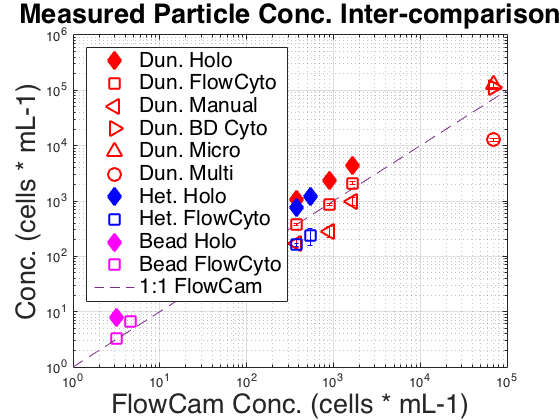

In [1]:
clear all 
close all
clc

% a script for loading the results of the gizmo concentration, finding the
% index of the corresponding samples, plotting the concentration against a
% given variable, color-coding the legend

% load the vars for dihm, ifcb, fc, manual, cc. dump each file in common
% folder
% load organismFC
load organismIFCB
% load organismFC_sum
load organismFC_sum_beads_Dec1
% load organismIFCB_sum
load organismDIHM

finalDIHM2 = struct('tag',{finalDIHM.sample},'meanConcDIHM',{finalDIHM.ans_conc_fit},'stdDIHM',1,'instrument','dihm')';

% function to combine all results into one structure
% final = [finalFC;finalIFCB;finalDIHM2];
listTags = [[finalDIHM2.tag]';[{finalFC.tag}]';[{finalIFCB.tag}]'];
finalTag = unique(listTags);


for i = 1:length(finalTag)
   temp = finalTag(i);
   
   temp2FC = [finalFC.meanConcFC];
   temp2IFCB = [finalIFCB.meanConcIFCB];
   temp2DIHM = [finalDIHM2.meanConcDIHM];
   
   temp2FCstd = [finalFC.stdFC];
   temp2IFCBstd = [finalIFCB.stdIFCB];
   temp2DIHMstd = [finalDIHM2.stdDIHM];
   
   tagIndexFC = strfind({finalFC.tag}, char(temp));
   tagIndexFC = find(~cellfun(@isempty,tagIndexFC));
   
   tagIndexIFCB = strfind({finalIFCB.tag}, char(temp));
   tagIndexIFCB = find(~cellfun(@isempty,tagIndexIFCB));
   
   tagIndexDIHM = strfind([finalDIHM2.tag], char(temp));
   tagIndexDIHM = find(~cellfun(@isempty,tagIndexDIHM));

   % conc
   final(i).tag = temp;
   final(i).concFC = temp2FC(tagIndexFC);
   final(i).concIFCB = temp2IFCB(tagIndexIFCB);
   final(i).concDIHM = temp2DIHM(tagIndexDIHM) ./ 1000;
   
   % std
   final(i).stdFC = temp2FCstd(tagIndexFC);
   final(i).stdIFCB = temp2IFCBstd(tagIndexIFCB);
   final(i).stdDIHM = temp2DIHMstd(tagIndexDIHM);
   
end

% zrinka
final(6).concZrinka           = 170941 ./1000;
final(7).concZrinka           = 282670 ./1000;
final(8).concZrinka           = 983315 ./1000;
final(6).stdZrinka        = 26976 ./1000;
final(7).stdZrinka        = 64471 ./1000;
final(8).stdZrinka        = 165529 ./1000;

% SMD results
final(25).tag = 'dunTer';

final(25).concFC = 70739;
final(25).concBD = 114198;
final(25).concMicro = 125400;
final(25).concMulti = 12834;

final(25).stdFC = 4743;
final(25).stdBD = 16575;
final(25).stdMicro = 13550;
final(25).stdMulti = 893;

% cell array to choose what samples to show in the graph, using sampleTag
paramVars = {'d','h'};

% choose what instrument to show on the x-axis
paramX = {'ifcb'};

% assign colors to each instrument
paramColor = {'r','b','m'};

% assign shape to each sample type
paramShape = {'square','diamond','<','>','^','o'};

si = 10; %marker size

figure(1);
set(gcf,'WindowStyle','docked')
dunFC = loglog([final(6:8).concFC],[final(6:8).concIFCB],'Marker',char(paramShape(1)),'Color',char(paramColor(1)),'MarkerSize',si,'LineStyle','none');
hold on
dunDIHM = loglog([final(6:8).concFC],[final(6:8).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(1)),'MarkerSize',si,'LineStyle','none','MarkerFaceColor',char(paramColor(1)));
dunZrinka = loglog([final(6:8).concFC],[final(6:8).concZrinka],'Marker',char(paramShape(3)),'Color',char(paramColor(1)),'MarkerSize',si,'LineStyle','none');
hetFC = loglog([final(9:13).concFC],[final(9:13).concIFCB],'Marker',char(paramShape(1)),'Color',char(paramColor(2)),'MarkerSize',si,'LineStyle','none');
hetDIHM = loglog([final(9:13).concFC],[final(9:13).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(2)),'MarkerSize',si,'LineStyle','none','MarkerFaceColor',char(paramColor(2)));
% beadDIHM = loglog([final(1:5).concFC],[final(1:5).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(3)),'LineStyle','none','MarkerFaceColor',char(paramColor(3)));

dunTerBD = loglog([final(25).concFC],[final(25).concBD],'Marker',char(paramShape(4)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
dunTerMicro = loglog([final(25).concFC],[final(25).concMicro],'Marker',char(paramShape(5)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
dunTerMulti = loglog([final(25).concFC],[final(25).concMulti],'Marker',char(paramShape(6)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);

beadIFCB = loglog([final(1:5).concFC],[final(1:5).concIFCB],'Marker',char(paramShape(1)),'Color',char(paramColor(3)),'LineStyle','none','MarkerSize',si);
beadDIHM = loglog([final(1:5).concFC],[final(1:5).concDIHM],'Marker',char(paramShape(2)),'Color',char(paramColor(3)),'LineStyle','none','MarkerSize',si,'MarkerFaceColor',char(paramColor(3)));


x=logspace(0,5);
y=x;
logg = loglog(x,y,'--');




errdunFC = errorbar([final(6:8).concFC],[final(6:8).concIFCB],[final(6:8).stdIFCB],    'Marker',char(paramShape(1)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errdunDIHM = errorbar([final(6:8).concFC],[final(6:8).concDIHM],[final(6:8).stdDIHM],    'Marker',char(paramShape(2)),'Color',char(paramColor(1)),'LineStyle','none','MarkerFaceColor',char(paramColor(1)),'MarkerSize',si);
errdunZrinka = errorbar([final(6:8).concFC],[final(6:8).concZrinka],[final(6:8).stdZrinka],    'Marker',char(paramShape(3)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errhetFC = errorbar([final(9:13).concFC],[final(9:13).concIFCB],[final(9:13).stdIFCB],    'Marker',char(paramShape(1)),'Color',char(paramColor(2)),'LineStyle','none','MarkerSize',si);
errhetDIHM = errorbar([final(9:13).concFC],[final(9:13).concDIHM],[final(9:13).stdDIHM],    'Marker',char(paramShape(2)),'Color',char(paramColor(2)),'LineStyle','none','MarkerFaceColor',char(paramColor(2)),'MarkerSize',si);
% errbeadDIHM = errorbar([final(1:5).concFC],[final(1:5).concDIHM],[final(1:5).stdDIHM],    'Marker',char(paramShape(2)),'Color',char(paramColor(3)),'LineStyle','none','MarkerFaceColor',char(paramColor(3)));

% errdunTerBD = errorbar([final(25).concFC],[final(25).concBD],[final(25).concBD],'Marker',char(paramShape(4)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errdunTerMicro = errorbar([final(25).concFC],[final(25).concMicro],[final(25).stdMicro],'Marker',char(paramShape(5)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errdunTerMulti = errorbar([final(25).concFC],[final(25).concMulti],[final(25).stdMulti],'Marker',char(paramShape(6)),'Color',char(paramColor(1)),'LineStyle','none','MarkerSize',si);
errorbarlogyy;

% herrdunFC = herrorbar([final(6:8).concFC],[final(6:8).concIFCB],[final(6:8).stdIFCB],'s');
% % herrdunDIHM = herrorbar([final(6:8).concFC],[final(6:8).concDIHM],[final(6:8).stdIFCB]);
% herrdunZrinka = herrorbar([final(6:8).concFC],[final(6:8).concZrinka],[final(6:8).stdIFCB],'<');
% herrhetFC = herrorbar([final(9:13).concFC],[final(9:13).concIFCB],[final(9:13).stdIFCB],'o');
% % herrhetDIHM = herrorbar([final(9:13).concFC],[final(9:13).concDIHM],[final(9:13).stdIFCB]);
% % herrbeadDIHM = herrorbar([final(1:5).concFC],[final(1:5).concDIHM],[final(1:5).stdIFCB]);
% errorbarlogxx

% set(herrdunFC,'LineStyle','-')
% set(herrdunDIHM,'LineStyle','-')
% set(herrdunZrinka,'LineStyle','-')
% set(herrhetFC,'LineStyle','-')
% set(herrhetDIHM,'LineStyle','-')
% set(herrbeadDIHM,'LineStyle','-')


% leg = legend(dunFC,dunDIHM);
% leg = legend([dunDIHM dunFC dunZrinka hetDIHM hetFC beadDIHM logg],{'Dun. DIHM','Dun. IFCB','Dun. Manual','Het. DIHM','Het. IFCB','Bead DIHM', '1:1 FC'});
% leg = legend([dunDIHM dunFC dunZrinka hetDIHM hetFC logg],{'Dun. DIHM','Dun. IFCB','Dun. Manual','Het. DIHM','Het. IFCB', '1:1 FC'});
leg = legend([dunDIHM dunFC dunZrinka dunTerBD dunTerMicro dunTerMulti hetDIHM hetFC beadDIHM beadIFCB logg],...
    {'Dun. Holo','Dun. FlowCyto','Dun. Manual','Dun. BD Cyto','Dun. Micro','Dun. Multi','Het. Holo','Het. FlowCyto', 'Bead Holo','Bead FlowCyto','1:1 FlowCam'});


leg.FontSize = 16;
set(leg,'Location','northwest')


title('Measured Particle Conc. Inter-comparison','FontSize', 20)
xlabel('FlowCam Conc. (cells * mL-1)','FontSize', 20)
ylabel('Conc. (cells * mL-1)','FontSize', 20)
grid on


dihmCount =sum(arrayfun(@(x) length(x.w_ESD),finalDIHM));

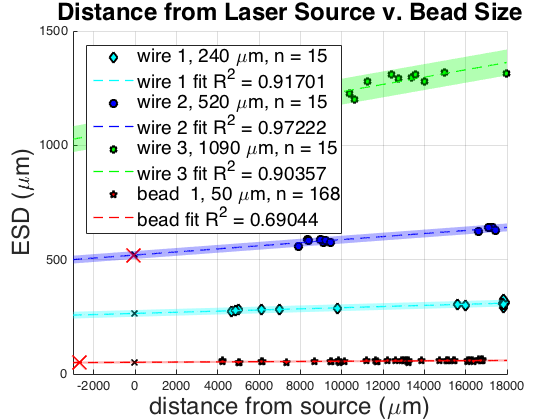

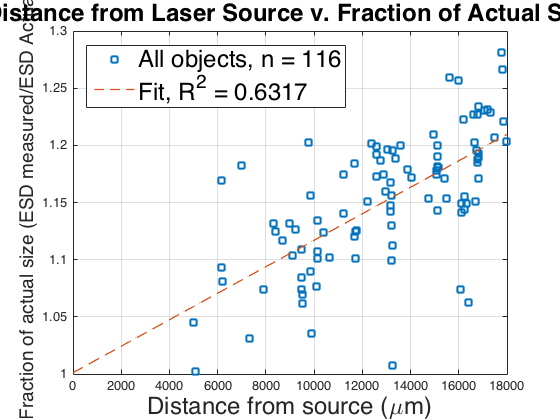

In [1]:
clear 
close all
clc

cd /Users/noahwalcutt/Documents/MatLab/FLK/wire_size_slope

load wire_data2

%% parameters
        normalize = 0; % 1 means that you divide by the actual size of the object
        actual_size = [240;520;1090;50;9]; % of 3 wires, 1 beads, 1 dunaliella.. microns
        actual_size_sensitivity = [10;10;10;0.08;1];
        actual_size_sensitivity = actual_size_sensitivity./actual_size;
        
        % define the range of the linear fit plot
        xlim_min = -3000;
        % xlim_min = 5000;
        % xlim_min = -150000;
        xlim_siz = 1;
%         xlim_max = 22000;
        xlim_max = 18000;
        xlim_vec = xlim_min:xlim_siz:xlim_max;

        % concatenate the wire sizes
        wire_z               = cat(2,w1_z, w2_z, w3_z);
        wire_esd             = cat(2,w1_esd, w2_esd, w3_esd);
        
        colors = {'c';'b';'g';'r';'m'};
        shape  = {'diamond';'o';'hexagram';'pentagram';'square'};

        %% plots for dunaliella

%         load FLK_data_gizmo_exp1_large
%         load dun_all_5000_22000
%         load usb_grab_scores_exp1_5697_holos
        
%         w_ESD = w_ESD.*(7/7.4);
%         ho = w_ESD>12 & w_ESD<17 & w_Y>-100 & w_Y<100;
%         ho = w_ESD>10;
%         w_ESD = w_ESD(ho);
%         w_X = w_X(ho);
%         w_Y = w_Y(ho);
%         w_Z = w_Z(ho);
%         plot(w_Z,w_ESD,'.')
% 
%           load dun_manual
%           w_ESD = dun_man_esd;
%           w_Z = dun_man_z;
%         
% %         end_index = 3000;
% %         x100_esd = ESD_exp1(1:end_index);
% %         x100_z = Z_exp1(1:end_index);
% %         x100_fid = filename_exp1(1:end_index);
% %         x100_fid_usb = usb_compare_megan(1:end_index);
% %         x100_peak = usb_numpeak(1:end_index);
% %         x100_x = X_exp1(1:end_index);
% %         x100_y = Y_exp1(1:end_index);
% %         
% %         iii = x100_peak <=1 & x100_z < max(x100_z) & x100_esd >= 7.5 & x100_esd <= 16 & x100_x >  -200 & x100_x<200;
% %         
%         i = 5;
%         
% %         [wire_plot(:,i),wire_plot_fit(:,i),myfit(:,i),myfit_s(:,i),myfit_y_bead,myfit_y_intercept(:,i),myfit_actual_intercept(:,i), polyval_Y_bead,polyval_DELTA_bead,~,~,rquared(:,i)] = ...
% %             wire_size_slope(   normalize,x100_z(iii),x100_esd(iii),actual_size(i),char(colors(i)), xlim_vec,shape(i),actual_size_sensitivity(i));
% 
%         [wire_plot(:,i),wire_plot_fit(:,i),myfit(:,i),myfit_s(:,i),myfit_y_bead,myfit_y_intercept(:,i),myfit_actual_intercept(:,i), polyval_Y_bead,polyval_DELTA_bead,~,~,rquared(:,i), myfit_y_max_sfz(:,i),polyval_DELTA_mean(:,i)] = ...
%             wire_size_slope(   normalize,  w_Z,w_ESD,actual_size(i),char(colors(i)), xlim_vec,shape(i),actual_size_sensitivity(i));

                hold on
                grid on        
        
                
%% plots for wire

        for i = 1:3
                figure(1)
                [wire_plot(:,i),wire_plot_fit(:,i),myfit(:,i),myfit_s(:,i),myfit_y(:,i),myfit_y_intercept(:,i),myfit_actual_intercept(:,i), polyval_Y(:,i),polyval_DELTA(:,i),wire_plot_actualintercept, wire_plot_yintercept,rquared(:,i), myfit_y_max_sfz(:,i),polyval_DELTA_mean(:,i)] = ...
                    wire_size_slope(   normalize,wire_z(:,i),wire_esd(:,i),actual_size(i),char(colors(i)), xlim_vec,shape(i),actual_size_sensitivity(i));

                
                % pause
        end

        
%                 hold on
%                 grid on        


%% plots for beads

        load stingray_organizer_final

        manualZ_refine = manualD~=50;
        bead_manualD = manualD(manualZ_refine);
        bead_manualZ = manualZ(manualZ_refine);
        
        i = 4;
        
        [wire_plot(:,i),wire_plot_fit(:,i),myfit(:,i),myfit_s(:,i),myfit_y_bead,myfit_y_intercept(:,i),myfit_actual_intercept(:,i), polyval_Y_bead,polyval_DELTA_bead,~,~,rquared(:,i), myfit_y_max_sfz(:,i),polyval_DELTA_mean(:,i)] = ...
            wire_size_slope(   normalize,bead_manualZ,bead_manualD,actual_size(i),char(colors(i)), xlim_vec,shape(i),actual_size_sensitivity(i));

cat_wireZ = [w1_z;w2_z;w3_z;bead_manualZ];
cat_wireSD = [w1_esd./240;w2_esd./520;w3_esd./1090;bead_manualD./50];

uuu = find(cat_wireZ>5000 & cat_wireZ < 18000);
cat_wireZ = cat_wireZ(uuu);
cat_wireSD = cat_wireSD(uuu);

        
%% titles, legend, etc.

        title('Distance from Laser Source v. Bead Size','fontsize', 18)
        xlabel('distance from source (\mum)','fontsize', 18)
        ylabel('ESD (\mum)','fontsize', 18)
        
        if normalize ==1
                 title('Distance from Laser Source v. Fraction of Actual Size','fontsize', 18)
                 ylabel('Fraction of actual size (normalized)','fontsize', 18)
        end
        

        xlim([xlim_min xlim_max])
        
        l = legend([wire_plot(:,1),wire_plot_fit(:,1),...
                    wire_plot(:,2),wire_plot_fit(:,2),...
                    wire_plot(:,3),wire_plot_fit(:,3),...
                    wire_plot(:,4),wire_plot_fit(:,4)],... % wire_plot_actualintercept(:,1),...
            ['wire 1, ',num2str(actual_size(1)),' \mum', ', n = ',num2str(length(wire_z(:,1)))],['wire 1 fit',' R^2',' = ',num2str(rquared(1))],...
            ['wire 2, ',num2str(actual_size(2)),' \mum', ', n = ',num2str(length(wire_z(:,2)))],['wire 2 fit',' R^2',' = ',num2str(rquared(2))],...
            ['wire 3, ',num2str(actual_size(3)),' \mum', ', n = ',num2str(length(wire_z(:,3)))],['wire 3 fit',' R^2',' = ',num2str(rquared(3))],...
            ['bead  1, ',num2str(actual_size(4)),' \mum', ', n = ',num2str(length(bead_manualZ))],['bead fit',' R^2',' = ',num2str(rquared(4))]);%,...
%             ['dunaliella, ',num2str(actual_size(5)),' \mum', ', n = ',num2str(length(dun_man_esd))],['dunaliella fit',' R^2',' = ',num2str(rquared(5))]);

        %                     wire_plot(:,5),wire_plot_fit(:,5)],...
            l.FontSize = 14;
            l.Location = 'northwest';
            
%% Plot the actual size v. the maximum size scale factor
% figure(5)
% plot(actual_size,myfit_y_max_sfz,'s','MarkerSize',14)
% hold on
% errorbar(actual_size,myfit_y_max_sfz,2.*polyval_DELTA_mean,'k.')
% xlabel('actual size (microns)','FontSize',14)
% ylabel('Maximum size scaling factor (at 18000 microns from source)','FontSize',14)
% title('Change in size scale factor as a function of particle size','FontSize',14)


%% Plot the combined fit
figure(66)
points = plot(cat_wireZ,cat_wireSD,'s');
hold on
% xlim_vec = 0:xlim_siz:xlim_max;

[P,S]=polyfit(cat_wireZ,cat_wireSD,1);
myfit_y = P(1)*(0:50:18000)+P(2);
myfit_y_max_sfz = P(1)*(18000)+P(2);
combo_wire_plot_fit = plot(0:50:18000,myfit_y,'LineWidth',1,'LineStyle','--');
                rquared = corrcoef(cat_wireZ,cat_wireSD);
                rquared = rquared(1,2);

title('Distance from Laser Source v. Fraction of Actual Size','fontsize', 18)
ylabel('Fraction of actual size (ESD measured/ESD Actual)','fontsize', 14)
xlabel('Distance from source (\mum)','fontsize', 18)
grid on
axis([0 18000 1 1.3])
lll = legend([points,combo_wire_plot_fit],['All objects, n = 116'],['Fit, R^2 = ',num2str(rquared)]);
            lll.FontSize = 18;
            lll.Location = 'northwest';

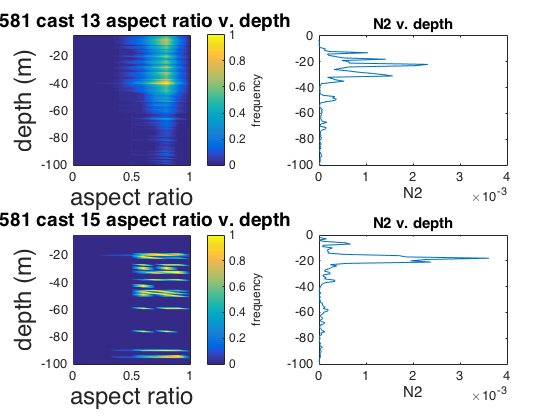

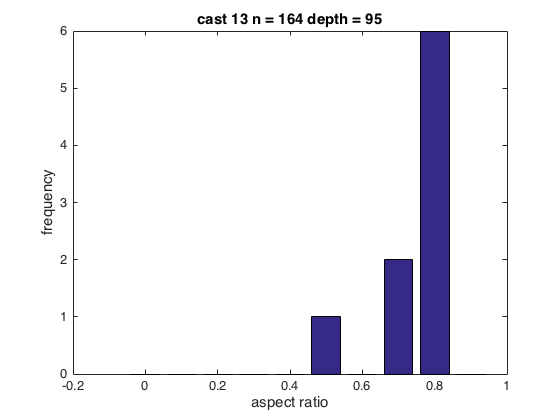

In [3]:
clear all
close all

cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_dashboard/dihm_dashboard_from_msi

% load(char(output_dihm_ctd_matched_merged))
cast = 13;
load(['data_merged',num2str(cast)])
% load(['ctd',num2str(cast)])

% start_dep = nanmin(merged.m_dep);
% stop_dep  = nanmax(merged.m_dep);
start_dep = 5;% min(merged.m_dep);
stop_dep  =  100;% max(merged.m_dep);
bin_size  = 1; % meters
bin       = start_dep:bin_size:stop_dep;
bina      = 0:.1:1;%0:.05:1;
bin_aspmed = zeros(length(bin),length(bina));

bot_idx = find(merged.m_dep == max(merged.m_dep)); 
bot_idx = min(bot_idx);

for i = 1:length(bin)-1
    j = find(merged.m_dep> bin(i) & merged.m_dep < bin(i+1) & merged.esd > 10);
    j = j<bot_idx;
    t13(i,1) = length(j);
%     bin_dep(i) = nanmean(merged.m_dep(j));
%     bin_flu(i) = nanmean(merged.m_fl(j));
%     bin_asp(i) = nanmean(merged.aspect(j));
%     bin_asp(i) = nanmean(merged.aspect(j));
%     
%     bin_depmed(i) = nanmedian(merged.m_dep(j));
%     bin_temmed(i) = nanmedian(merged.m_t(j));
%     bin_flumed(i) = nanmedian(merged.m_fl(j));
%     bin_aspmed(i) = nanmedian(merged.aspect(j));
%     bin_esdmed(i) = nanmedian(merged.esd(j));

%     bin_depmed(i,:) = histcounts(merged.m_dep(j),bina);
    bin_temp = histcounts(merged.aspect(j),bina);
%     bin_temp = bin_temp./max(bin_temp);
%     bin_temp = bin_temp./t13(i);

    for u = 1:length(bina)-1
        if isnan(bin_temp(u)) == 1
            bin_temp(u) =0;
        end
%         if t13(u) >  50
%             bin_temp(u) =0;
%         end
       bin_aspmed(i,u) = bin_temp(u); 
    end

%     bin_temmed(i,:) = histcounts(merged.m_t(j));
%     bin_flumed(i,:) = histcounts(merged.m_fl(j));
%     bin_esdmed(i,:) = histcounts(merged.esd(j));

figure(2)
bar(bina(1:end-1),bin_temp)
title(['cast 13 n = ', num2str(t13(i,1)), ' depth = ', num2str(i)])
xlabel('aspect ratio')
ylabel('frequency')
% pause

end

% bin_aspmed(95,9) == [];
% figure(cast)
bin_aspmed = bin_aspmed./(max(max(bin_aspmed)));
figure(1)
subplot(221)
pcolor(bina,-stop_dep:bin_size:-start_dep,flipud(bin_aspmed))
shading interp

title(['EN581 cast ', num2str(cast),' aspect ratio v. depth'],'FontSize',14)
xlabel('aspect ratio','FontSize',18)
ylabel('depth (m)','FontSize',18)
c = colorbar;

c.Label.String = 'frequency';

%% N-squared calculations and plot
load ctd_13.mat
SA = Sal00;
CT = Potemp190C;
p = PrDM; %10.1325;% dbar
[N2, p_mid] = gsw_Nsquared(SA,CT,p);

subplot(222)
plot(N2,-DepSM(1:end-1))
title('N2 v. depth')
xlabel('N2')

xlim([0 4e-03])
ylim([-stop_dep 0])

%% aspect for 15

clear j box_idx bin_aspmed

cast = 15;
load(['data_merged',num2str(cast)])

% start_dep = nanmin(merged.m_dep);
% stop_dep  = nanmax(merged.m_dep);
start_dep = 5;%min(merged.m_dep);
stop_dep  =  100;% max(merged.m_dep);
bin_size  = 1; % meters
bin       = start_dep:bin_size:stop_dep;
bina      = 0:.1:1;%0:.05:1;
bin_aspmed = zeros(length(bin),length(bina));

bot_idx = find(merged.m_dep == max(merged.m_dep));
bot_idx = min(bot_idx);

for i = 1:length(bin)-1
    j = find(merged.m_dep> bin(i) & merged.m_dep < bin(i+1) & merged.esd > 50); % remove the upcast here
    j = j<bot_idx;
    t15(i,1) = length(j);



%     bin_dep(i) = nanmean(merged.m_dep(j));
%     bin_flu(i) = nanmean(merged.m_fl(j));
%     bin_asp(i) = nanmean(merged.aspect(j));
%     bin_asp(i) = nanmean(merged.aspect(j));
%     
%     bin_depmed(i) = nanmedian(merged.m_dep(j));
%     bin_temmed(i) = nanmedian(merged.m_t(j));
%     bin_flumed(i) = nanmedian(merged.m_fl(j));
%     bin_aspmed(i) = nanmedian(merged.aspect(j));
%     bin_esdmed(i) = nanmedian(merged.esd(j));

%     bin_depmed(i,:) = histcounts(merged.m_dep(j),bina);
    bin_temp = histcounts(merged.aspect(j),bina);
    bin_temp = bin_temp./max(bin_temp);
%     bin_temp = bin_temp./t15(i);

    for u = 1:length(bina)-1
        if isnan(bin_temp(u)) == 1
            bin_temp(u) =0;
        end
%         if t13(u) >  50
%             bin_temp(u) =0;
%         end
       bin_aspmed(i,u) = bin_temp(u); 
    end

%     bin_temmed(i,:) = histcounts(merged.m_t(j));
%     bin_flumed(i,:) = histcounts(merged.m_fl(j));
%     bin_esdmed(i,:) = histcounts(merged.esd(j));

% 
% figure(3)
% bar(bina(1:end-1),bin_temp)
% title(['cast 13 n = ', num2str(t13(i,1)), ' depth = ', num2str(i)])
% pause

end

% bin_aspmed(95,9) == [];
% figure(cast)
figure(1)

subplot(223)
pcolor(bina,-stop_dep:bin_size:-start_dep,flipud(bin_aspmed))
shading interp

title(['EN581 cast ', num2str(cast),' aspect ratio v. depth'],'FontSize',14)
xlabel('aspect ratio','FontSize',18)
ylabel('depth (m)','FontSize',18)
c = colorbar;

c.Label.String = 'frequency';


%% N-squared calculations and plot
load ctd_15
SA = Sal00;
CT = Potemp190C;
p = PrDM; %10.1325;% dbar
[N2, p_mid] = gsw_Nsquared(SA,CT,p);

subplot(224)
plot(N2,-DepSM(1:end-1))

hold on

ylim([-stop_dep 0])
title('N2 v. depth')
xlabel('N2')
xlim([0 4e-03])


% figure()
% shading flat

% plot_aspect_bin = figure(1);
% asp = plot(bin_aspmed,-bin_depmed,'.');
% hold on
% 
% flu = plot(bin_flumed./nanmax(bin_flumed),-bin_depmed);
% temp = plot(bin_temmed./nanmax(bin_temmed),-bin_depmed);
% 
% xlabel('aspect ratio, fluor, temp (normalized)')
% ylabel('depth (m)')
% t = title([char(output_ctd_unique_names_dihm),' Aspect Ratio v. Depth']);
% set(t, 'Interpreter', 'none')
% 
% l = legend([asp,flu,temp],{'aspect','fluor','temp'});
% l.Location = 'Southeast';

% fid = [char(output_dihm_dir),'\aspect.png'];
% saveas(plot_aspect_bin,fid)

% clf

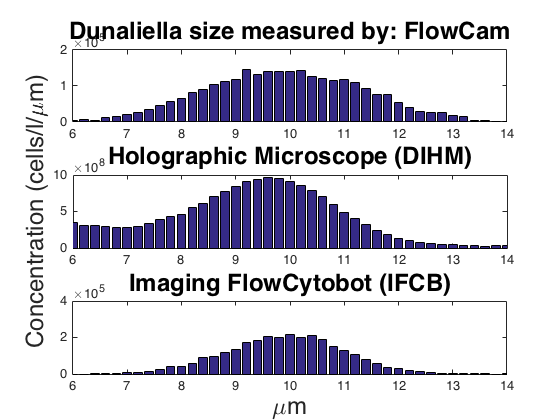

In [11]:
%% compare size spectrums
clear all
close all


cd /Users/noahwalcutt/Documents/MatLab/FLK/fc


load fc_esd

load dihm_esd
load /Users/noahwalcutt/Documents/MatLab/FLK/FLK_data_gizmo_exp1_large
% load ans_abundance_exp1_dun
% ans_dihm_abundance = ans_abundance_histogram./2096./(((pi * 1.0639e+03.^2 * 18000) - (pi * 272.^2 * 5000))/1e+15);

load ifcb_esd
load ifcb_esd2
load ifcb_esd3

load ifcb_exp1_major_ax_dunal



bw = .2;
pixelmicron_ifcb = 3.4; % this number may change slightly during beads experiment

%% FC
figure(1)
subplot(3,1,1)
bins = 4.4:bw:16;
vol_fc = 0.0144768;
fc_psd = hist(esd_diameter,bins);
fc_psd(1,42) = 80;
fc_psd(1,43) = 75;
fc_psd(1,44) = 50;
bar(bins,fc_psd./(vol_fc*bw))
% bar(bins,fc_psd./(vol_fc*bw)./bw./max(fc_psd./(vol_fc*bw)./bw))

% axis([4 16 0 1.5e5])
conc_fc = sum(fc_psd/vol_fc);

title('Dunaliella size measured by: FlowCam', 'fontsize', 18)
xlim([6 14])
% axis([6 14 0 500000])

%% DIHM 
subplot(3,1,2)
vol_dihm = ((pi * 1.0639e+03.^2 * 18000) - (pi * 272.^2 * 5000))/1e+15;

% dihm_corrected_esd = ESD_exp1-Z_exp1*3.515e-4;
% dihm_corrected_esd = ESD_exp1-Z_exp1*1.3e-4;

           ESD_exp1 = ESD_exp1.*(7/7.4);
           dihm_size_slope_max_fraction_decrease = .15;
           % fraction of the maximum decrease
                fraction_from_source = Z_exp1./(18000); % true source is at source, z = 0. updated sept 8, chagned to 18000 Sept 21

            % fraction of decrease percentage
                fraction_decrease = dihm_size_slope_max_fraction_decrease.*fraction_from_source;
                w_ESD_temp = ESD_exp1.*(1-fraction_decrease);

            % compute amount of decrease    
                ans_ESD_adjust_amount = w_ESD_temp - ESD_exp1; % microns

            % final correction
                ESD_exp1 = ESD_exp1.*(1-fraction_decrease);
    
                dihm_corrected_esd = ESD_exp1;
    
    

% dihm_psd = hist(ESD_exp1,bins);
dihm_psd = hist(dihm_corrected_esd,bins);

dihm_psd(1,1)=0;% added aug 1
dihm_psd(1,59)=0;
dihm_psd(1,2) = 0;
dihm_psd(1,3) = 100;
dihm_psd(1,4) = 150;
% dihm_psd(1,1:14)=0;

% t2 = 4.4:.2:16;
% e = exp(1);
% f2 = 9960*e.^(-.2*(t2-11.2).^2); % area of dun
% for ii = 1:15
%     dihm_psd(1,15+ii)=f2(15+ii);
% end
% 
% dihm_psd(1,15) = 0;

% bar(bins,dihm_psd/(vol_dihm*bw)    ./  max(dihm_psd/(vol_dihm*bw)))
bar(bins,dihm_psd/(vol_dihm*bw))

% axis([4 16 0 1.5e5])
conc_fc = sum(dihm_psd/vol_dihm);

title('Holographic Microscope (DIHM)', 'fontsize', 18)
ylabel('Concentration (cells/l/\mum)', 'fontsize', 18)
xlim([6 14])

%% IFCB. Still low as of 7 10 17. May be because of how ifcb software draws boundaries.
subplot(3,1,3)
% vol_ifcb = 0.005616;
% vol_ifcb2 = .0091295;
% vol_ifcb3 = 0.0118239;
vol_ifcb = 0.0118239;

% ifcb_vol=vol_ifcb+vol_ifcb2+vol_ifcb3;

% EquivDiameter = EquivDiameter3/pixelmicron_ifcb; % aug 14, 2017
Major = MajorAxisLength/pixelmicron_ifcb;

% ifcb_psd = hist(EquivDiameter,bins); % aug 14, 2017
ifcb_psd = hist(Major,bins);
% ifcb_psd2 = hist(EquivDiameter2./3.4,bins);
% ifcb_psd3 = hist(EquivDiameter3./3.4,bins);

% ifcb_psd=ifcb_psd+ifcb_psd2+ifcb_psd3;

ifcb_psd(1,18)=100;
ifcb_psd(1,19)=100;

ifcb_psd(1,31) = 500;
ifcb_psd(1,32) = 450;
ifcb_psd(1,33) = 350;

% bar(bins,(ifcb_psd/(vol_ifcb)))
% bar(bins,   (ifcb_psd/vol_ifcb/bw)   ./ max(ifcb_psd/vol_ifcb/bw))
bar(bins,   (ifcb_psd/vol_ifcb/bw)   )

% axis([4 16 0 3e4])
title('Imaging FlowCytobot (IFCB)', 'fontsize', 18)
xlabel('\mum', 'fontsize', 18)
xlim([6 14])

%% evaluate dunaliella slope
% figure(33)
% hi = hist2(ESD_exp1,Z_exp1,1:.5:15,5000:100:15000);
% pcolor(5000:100:15000,1:.5:15,hi')
% 
% figure(35)
% yu = find(ESD_exp1>7 & ESD_exp1<16 & Z_exp1<14900);
% histogram(ESD_exp1(yu))
% 
% figure(31)
% scatter(Z_exp1(yu),ESD_exp1(yu),'.')
% hold on
% myfit_manual = polyfit(Z_exp1(yu),ESD_exp1(yu),1);
% ha = myfit_manual(1)*(5000:1:14500)+myfit_manual(2);
% plot(5000:1:14500,ha);
% hold off


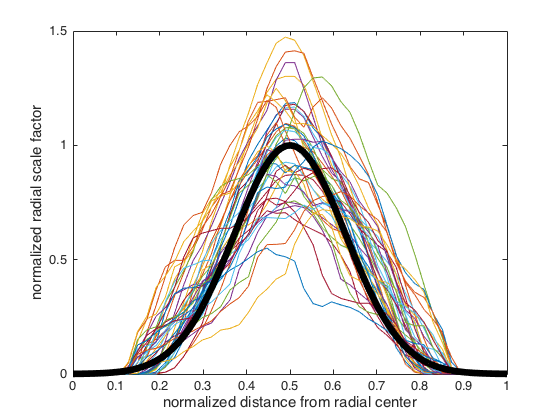

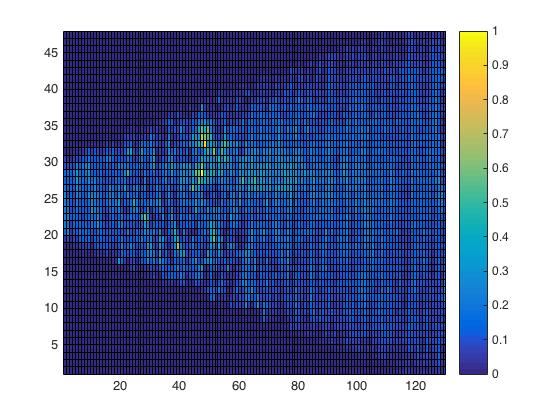

In [13]:
clear all
close all

cd /Users/noahwalcutt/Documents/MatLab/FLK/dihm_analysis


% w_ESD = [];
% w_X = [];
% w_Y = [];
% w_Z = [];
% 
% 
% for i = 1:3
%    s = load(['dun',num2str(i)]);
%   
%     w_ESD = cat(1,w_ESD,s.w_ESD);
%     w_X = cat(1,w_X,s.w_X);
%     w_Y = cat(1,w_Y,s.w_Y);
%     w_Z = cat(1,w_Z,s.w_Z);
%    
%     
% end

load dun_all_mmo

hi = w_X> -100 & w_X<100; % take a slice through the middle
[ru] = histcounts2(w_Z(hi),w_Y(hi),5000:100:18000,-1200:50:1200); % draw a histogram of the middle slice
figure(1)
pcolor(ru'./max(max(ru))) % normalize by the maximum bin in the histogram
grid off
colorbar


figure(2)
for u = 4:48 % loop through the z direction of the matrix ru
   plot(linspace(0,1,length(ru(u,:))),smooth(ru(u,:)./max(ru(u,:)),  15  )/.5) % smooth the distribution of scores in each plane
   hold on
%    axis([.3 .7 0 1])
   % pause
   
end

% fit a cuve to the smoothed distribution of scores in each plane
peak = 1;
width = 30;
range = 0:.01:1;
e = exp(1);
center = .5;

f1 = peak*e.^(-width*(range-center).^2);
plot(range,f1,'k','LineWidth',5)

xlabel('normalized distance from radial center')
ylabel('normalized radial scale factor')


Error using cd
Cannot CD to /Volumes/holograms/raw/gizmo_experiment/Env_sample_3/rec1 (Name is nonexistent or not a directory).



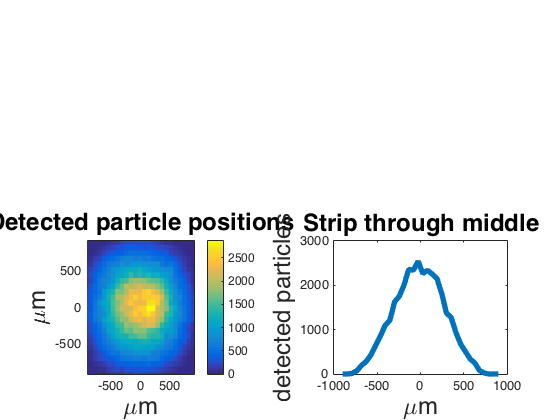

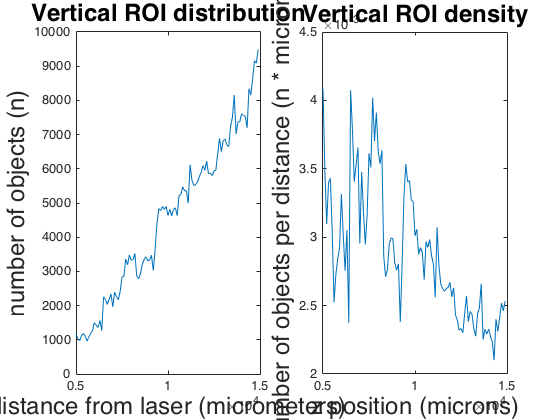

In [14]:
clear all
close all
clc

cd /Users/noahwalcutt/Documents/MatLab/FLK/

% compute r(z)
load FLK_data_exp1_all

% locate r max in slice 1

xbin = [-1250:75:1250];
xbin2 = xbin(1:end-1)+75/2;

ybin = [-1250:75:1250];
ybin2 = ybin(1:end-1)+75/2;

zslice = min(Z):100:14900;
[Xbin,Ybin] = meshgrid(xbin2,ybin2);

radius_empirical = sqrt(X.^2+Y.^2); % find the radius for each point

for hi = 1:length(zslice)
    
s1 = find(Z == zslice(hi));
radius_geometric_max = 0.08*zslice(hi) - 100; % formula for radius as a function of 
area_per_slice(hi,1) = pi*radius_geometric_max.^2;
radius_inliers = find(radius_empirical(s1) <= radius_geometric_max);  


h = histcounts2(X(radius_inliers),Y(radius_inliers),xbin,ybin);
% figure(1)
% colormap(jet)
% 
% pcolor(Xbin,Ybin,log10(h/max(h(:))));
% title([num2str(zslice(hi)), ' inliers = ' , num2str(length(radius_inliers)), ' total = ', num2str(length(s1))])
% shading flat
% colorbar
% 
% 
% 
% % area(hi,1)=pi*
zsum(hi,1) = sum(h(:));
% 
% pause
end
% z1 5000, r1 = 300, z2 = 15000, r2 = 1100 -- solve for m and b -- m = .08
% b = -100

figure(2)
subplot(121)
plot(zslice,zsum)
title('Vertical ROI distribution','fontsize',18)
xlabel('distance from laser (micrometers)','fontsize',18)
ylabel('number of objects (n)','fontsize',18)

subplot(122)
plot(zslice,zsum./area_per_slice)
title('Vertical ROI density','fontsize',18)
xlabel('z position (microns)','fontsize',18)
ylabel('number of objects per distance (n * micron-2)','fontsize',18)

% collapse all the particle X Y positions into one hologram
raw_collapsed_xy = hist2(X,Y,xbin,ybin);
figure(3)
subplot(223)
pcolor(xbin,ybin,raw_collapsed_xy)
axis([-900 900 -900 900])
title('Detected particle positions','fontsize',18)
xlabel('\mum','fontsize',18)
ylabel('\mum','fontsize',18)
shading flat
colorbar

subplot(224)
mm = max(raw_collapsed_xy(:,17)+raw_collapsed_xy(:,18));
plot(linspace(-900,900,34),raw_collapsed_xy(:,17)+raw_collapsed_xy(:,18)./mm,'LineWidth',4)
title('Strip through middle','fontsize',18)
xlabel('\mum','fontsize',18)
ylabel('detected particles','fontsize',18)


% average intensities over raw holograms
% r = '/Users/noahwalcutt/Desktop/falkor_gizmo_reports/env_exp3/raw'; %
% modified Nov 27 2017
r = '/Volumes/holograms/raw/gizmo_experiment/Env_sample_3/rec1';
raw = dir(r);
cd(r)
lr = length(dir('*.bmp'));
tot_obj_std = zeros(lr,1);
tot_background = zeros(2060,2056);
ii = 1;

for ji = 4:lr
    workings = imread(raw(ji).name);
    tot_background = tot_background+double(workings);
    ii = ii+1;
    
end

tot_background_average = floor(tot_background/ii);

% startx = 1;
% starty = 1;
% for rr = 1:26
%     for re = 1:26
%     tot_downsamp(rr,re) = sum(sum(tot_background_average(startx:(startx+75),starty:(starty+75))));    
%     end
%     starty = 1;
%     startx = startx + 75;
% end


% figure(4)
subplot(221)
% pcolor(xbin,ybin,raw_collapsed_xy)
pcolor(tot_background_average)
title('Raw holo. avg. pixel intensities','fontsize',18)
xlabel('pixel','fontsize',18)
ylabel('pixel','fontsize',18)
shading flat
shading interp
colorbar

subplot(222)
% plot(tot_background_average(:,1030)+tot_background_average(:,1031))
u99 = smooth(tot_background_average(:,1030)+tot_background_average(:,1031),100);
plot(40.*u99./max(u99),'LineWidth',4)
title('Strip through middle','fontsize',18)
xlabel('pixel','fontsize',18)
ylabel('pixel intensity','fontsize',18)
xlim([0 2000])
ylim([40*0.2 40*1.1])


figure(11)
pcolor(xbin,ybin,raw_collapsed_xy)
title('Hologram pipeline horizontal spatial ROI distribution','fontsize',18)
xlabel('X-position (micrometers)','fontsize',18)
ylabel('Y-position (micrometers)','fontsize',18)
h = colorbar;
ylabel(h, 'number of objects','fontsize',18)
shading flat

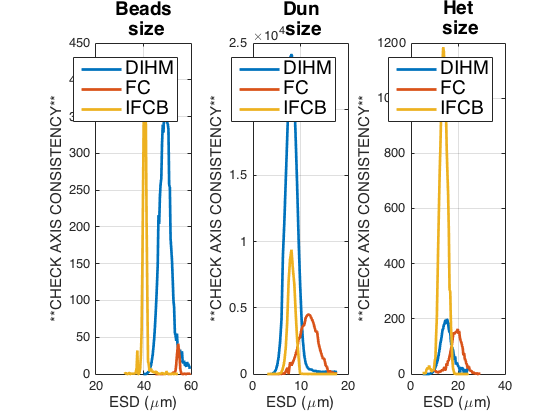

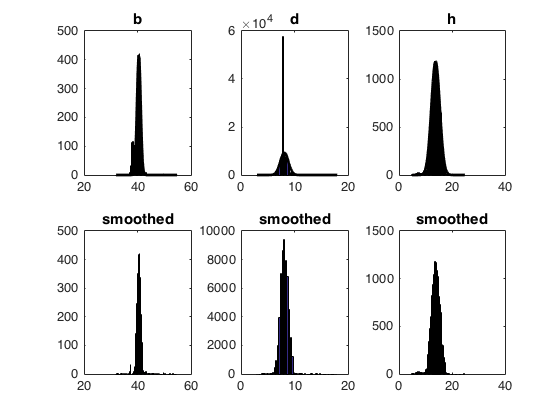

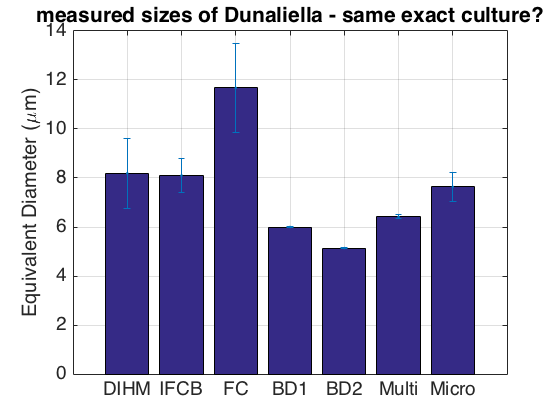

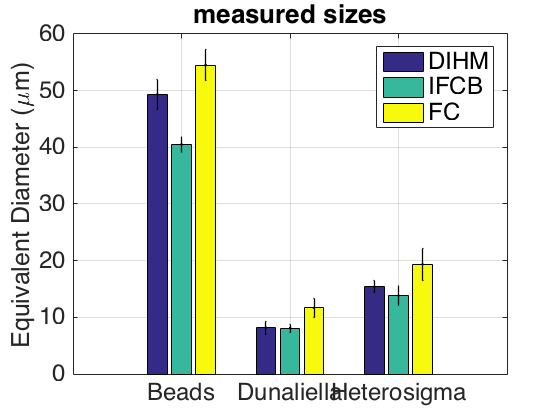

In [1]:
clear all 
close all
clc

%% load the vars for dihm, ifcb, fc, manual, cc. dump each file in common
load organismDIHM
load fcParticleSizes
load ifcbParticleSizes

%% 1 - concatenate each of the cultures into large array for the DIHM
    final(1).tag = {'b'};
    final(2).tag = {'d'};
    final(3).tag = {'h'};
    final(1).sizeRawDIHM = cat(1,finalDIHM(1).w_ESD,finalDIHM(2).w_ESD,finalDIHM(3).w_ESD,finalDIHM(4).w_ESD,finalDIHM(5).w_ESD);
    final(2).sizeRawDIHM = cat(1,finalDIHM(6).w_ESD,finalDIHM(7).w_ESD,finalDIHM(8).w_ESD);
    final(3).sizeRawDIHM = cat(1,finalDIHM(9).w_ESD,finalDIHM(10).w_ESD,finalDIHM(11).w_ESD,finalDIHM(12).w_ESD,finalDIHM(13).w_ESD);

%% 2 - concatenate each of the cultures into large array for the fc
    final(1).sizeRawFC = [];
        for i = 1:15
           temp =  fc(i).esd;
           final(1).sizeRawFC = cat(1,final(1).sizeRawFC,temp);
        end

    final(2).sizeRawFC = [];
        for i = 16:24
           temp =  fc(i).esd;
           final(2).sizeRawFC = cat(1,final(2).sizeRawFC,temp);
        end

    final(3).sizeRawFC = [];
        for i = 25:40
           temp =  fc(i).esd;
           final(3).sizeRawFC = cat(1,final(3).sizeRawFC,temp);
        end

%% 3 - concatenate each of the cultures into large array for the ifcb
    final(1).sizeRawIFCB = [];
        for i = 1:15
           temp =  ifcb(i).esd;
           final(1).sizeRawIFCB = cat(1,final(1).sizeRawIFCB,temp);
        end

    final(2).sizeRawIFCB = [];
        for i = 16:24
           temp =  ifcb(i).esd;
           final(2).sizeRawIFCB = cat(1,final(2).sizeRawIFCB,temp);
        end

    final(3).sizeRawIFCB = [];
        for i = 25:39
           temp =  ifcb(i).esd;
           final(3).sizeRawIFCB = cat(1,final(3).sizeRawIFCB,temp);
        end
    
    
%% 4 - plot the histogram of the combined arrays for DIHM
    bins = {[40:.3:60];[3:.3:18];[5:.3:25]};
    peak = [371;2.41e+04;200];
    center = [49;8.1;15];
    width = [.1;.4;.1];
    range = bins;
    confidence = .1;
    
    for i = 1:length(final)
        figure(1)
        subplot(2,3,i)
        shist = histcounts(final(i).sizeRawDIHM, bins{i,1});
        [aHistogram, func, final(i).sizeSmoothedDIHM] = gizmoFitHistogram(shist,peak(i),width(i),center(i),range{i,1},bins{i,1},final(i).tag, confidence);
        final(i).sizeBinsDIHM = bins{i,1}; % 12/19/2017
        temp = bins{i,1};

        subplot(2,3,i+3)
        bar(temp(1:end-1),final(i).sizeSmoothedDIHM)
        title('smoothed')

        [final(i).sizeWeightedDIHM,final(i).sizeWeightedDIHMstd] = gizmoWeighted(final(i).sizeSmoothedDIHM,temp);

        % pause
        clear shist temp
    end

%% 5 - FC plot the histogram of the combined arrays for fc
clf
    bins = {[45:.3:60];[3:.3:18];[10:.3:30]};
    peak = [41;4499;166];
    center = [54.6;11.7;19.5];
    width = [1.7;.15;.1];
    range = bins;
    confidence = .1;
    
    for i = 1:length(final)
    figure(1)
    subplot(2,3,i)
    shist = histcounts(final(i).sizeRawFC, bins{i,1});
    [aHistogram, func, final(i).sizeSmoothedFC] = gizmoFitHistogram(shist,peak(i),width(i),center(i),range{i,1},bins{i,1},final(i).tag, confidence);
    final(i).sizeBinsFC = bins{i,1}; % 12/19/2017
    temp = bins{i,1};

    subplot(2,3,i+3)
    bar(temp(1:end-1),final(i).sizeSmoothedFC)
    title('smoothed')

    [final(i).sizeWeightedFC,final(i).sizeWeightedFCstd] = gizmoWeighted(final(i).sizeSmoothedFC,temp);

%     pause
    clear shist temp
    end


%% 6 - IFCB plot the histogram of the combined arrays for ifcb
    bins = {[32:.3:55];[3:.3:18];[5:.3:25]};
    peak = [421;9385;1185];
    center = [40.5;8.1;13.8];
    width = [1.1;.9;.2];
    range = bins;
    confidence = .1;
    clf
    for i = 1:length(final)
    figure(1)
    subplot(2,3,i)
    shist = histcounts(final(i).sizeRawIFCB, bins{i,1});
    [aHistogram, func, final(i).sizeSmoothedIFCB] = gizmoFitHistogram(shist,peak(i),width(i),center(i),range{i,1},bins{i,1},final(i).tag, confidence);
    final(i).sizeBinsIFCB = bins{i,1}; % 12/19/2017
    temp = bins{i,1};

    subplot(2,3,i+3)
    bar(temp(1:end-1),final(i).sizeSmoothedIFCB)
    title('smoothed')

    [final(i).sizeWeightedIFCB,final(i).sizeWeightedIFCBstd] = gizmoWeighted(final(i).sizeSmoothedIFCB,temp);

%     pause
    clear shist temp
    end


%% 7 - smd data
    
final(2).sizeWeightedBD1 = 6;
final(2).sizeWeightedBD2 = 5.14;
final(2).sizeWeightedMulti = 6.41;
final(2).sizeWeightedMicro = 7.64;

final(2).sizeWeightedBD1std = .04;
final(2).sizeWeightedBD2std = .03;
final(2).sizeWeightedMultistd = .08;
final(2).sizeWeightedMicrostd = .6;

%% make bar plot with error for each
    bead = [final(1).sizeWeightedDIHM, final(1).sizeWeightedIFCB, final(1).sizeWeightedFC];
    dun = [final(2).sizeWeightedDIHM, final(2).sizeWeightedIFCB, final(2).sizeWeightedFC];
	dunAll = [final(2).sizeWeightedDIHM, final(2).sizeWeightedIFCB, final(2).sizeWeightedFC,...
        final(2).sizeWeightedBD1,final(2).sizeWeightedBD2,final(2).sizeWeightedMulti,final(2).sizeWeightedMicro];
    het = [final(3).sizeWeightedDIHM, final(3).sizeWeightedIFCB, final(3).sizeWeightedFC];
    combinedPart = [bead;dun;het];
    
    ebead = [final(1).sizeWeightedDIHMstd, final(1).sizeWeightedIFCBstd, final(1).sizeWeightedFCstd];
    edun = [final(2).sizeWeightedDIHMstd, final(2).sizeWeightedIFCBstd, final(2).sizeWeightedFCstd];
    edunAll = [final(2).sizeWeightedDIHMstd, final(2).sizeWeightedIFCBstd, final(2).sizeWeightedFCstd,...
        final(2).sizeWeightedBD1std,final(2).sizeWeightedBD2std,final(2).sizeWeightedMultistd,final(2).sizeWeightedMicrostd];
    ehet = [final(3).sizeWeightedDIHMstd, final(3).sizeWeightedIFCBstd, final(3).sizeWeightedFCstd];
    combinedPartE = [ebead;edun;ehet];
    
    figure(3)    
    sizesBar = bar([1:3],combinedPart);
    title('measured sizes')
    ylabel('Equivalent Diameter (\mum)','FontSize',18)
    l = legend('DIHM','IFCB','FC');
    l.FontSize = 18;
    
        lab = get(gca,'xticklabel');
        lab(1) = {'Beads'};
        lab(2) = {'Dunaliella'};
        lab(3) = {'Heterosigma'};
        set(gca,'xticklabel',lab)
        set(gca,'FontSize',18)
        
        grid on
        
for k1 = 1:size(combinedPart,1)
    ctr(k1,:) = bsxfun(@plus, sizesBar(1).XData, [sizesBar(k1).XOffset]');
    ydt(k1,:) = sizesBar(k1).YData;
end
hold on
errorbar(ctr, ydt, combinedPartE, 'k.','LineWidth',1)
hold off

 %% Dun only       
    figure(7)    
    bar([1:7],[dunAll]);
    hold on
    errorbar([1:7],[dunAll],edunAll,'.');
    title('measured sizes of Dunaliella - same exact culture?')
    ylabel('Equivalent Diameter (\mum)','FontSize',18)
%     l = legend('DIHM','IFCB','FC');
%     l.FontSize = 18;
    
        lab = get(gca,'xticklabel');
        lab(1) = {'DIHM'};
        lab(2) = {'IFCB'};
        lab(3) = {'FC'};
        lab(4) = {'BD1'};
        lab(5) = {'BD2'};
        lab(6) = {'Multi'};
        lab(7) = {'Micro'};
        set(gca,'xticklabel',lab)
        set(gca,'FontSize',14)
        
        grid on
        
%     hold on
%     errorbar([1:3],[bead;dun;het],[ebead;edun;ehet],'.')


%% Show PSD for Het, Dun, Bead following Lee-Karp Boss 2007

titlePSD = {'Beads';'Dun';'Het'};
ui =2;

for i = 1:3
    figure(9)
    subplot(1,3,i)
    d = [final(i).sizeBinsDIHM];
    plot(d(1:end-1),[final(i).sizeSmoothedDIHM],'LineWidth',ui)
    
    hold on
    f = [final(i).sizeBinsFC];
    plot(f(1:end-1),[final(i).sizeSmoothedFC],'LineWidth',ui)
    
    ifc = [final(i).sizeBinsIFCB];
    plot(ifc(1:end-1),[final(i).sizeSmoothedIFCB],'LineWidth',ui)
    clear d f ifc
    
%     ylim([0 1.2])
    title([titlePSD(i),' size'],'FontSize',14)
    xlabel('ESD (\mum)')
    ylabel('**CHECK AXIS CONSISTENCY**')
    l = legend('DIHM','FC','IFCB');
    l.FontSize = 14;
    grid on
end


% 
%     figure(9)
%     subplot(1,3,i)
%     d = [final(i).sizeBinsDIHM];
%     plot(d(1:end-1),[final(i).sizeSmoothedDIHM]./max([final(i).sizeSmoothedDIHM]),'LineWidth',ui)
%     
%     hold on
%     f = [final(i).sizeBinsFC];
%     plot(f(1:end-1),[final(i).sizeSmoothedFC]./max([final(i).sizeSmoothedFC]),'LineWidth',ui)
%     
%     ifc = [final(i).sizeBinsIFCB];
%     plot(ifc(1:end-1),[final(i).sizeSmoothedIFCB]./max([final(i).sizeSmoothedIFCB]),'LineWidth',ui)


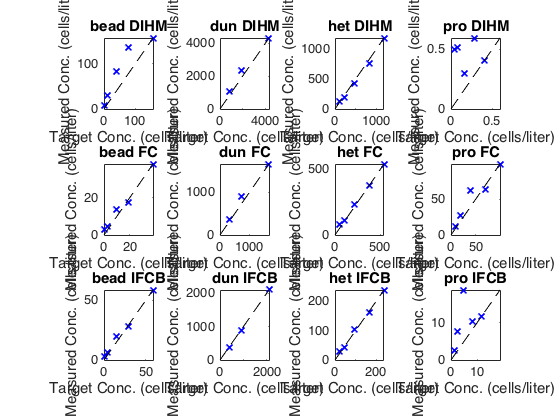

In [1]:
clear all 
close all
clc

% a script for plotting the relative error
load organismIFCB_20180102_consolidated
load organismfc_Jan4
load organismDIHM_20171229

finalDIHM2 = struct('tag',{finalDIHM.sample},'meanConcDIHM',{finalDIHM.ans_conc_fit},'stdDIHM',1,'instrument','dihm')';

%% list all the dilution amounts
targetDilution = [.015;.0625;.25;.5;1;... % b
                        .20;.44;1;...% d
                        .1;.2;.4;.7;1;...% h
                        .1;.2;.4;.7;1;...
                        0;0;0;0;0;0]; % p

%% function to combine all results into one structure
% final = [finalFC;finalIFCB;finalDIHM2];
listTags = [[finalDIHM2.tag]';[{finalFC.tag}]';[{finalIFCB.tag}]'];
finalTag = unique(listTags);

for i = 1:length(finalTag)
   temp = finalTag(i);
   
   temp2FC = [finalFC.meanConcFC];
   temp2IFCB = [finalIFCB.meanConcIFCB];
   temp2DIHM = [finalDIHM2.meanConcDIHM];
   
   temp2FCstd = [finalFC.stdFC];
   temp2IFCBstd = [finalIFCB.stdIFCB];
   temp2DIHMstd = [finalDIHM2.stdDIHM];
   
   tagIndexFC = strfind({finalFC.tag}, char(temp));
   tagIndexFC = find(~cellfun(@isempty,tagIndexFC));
   
   tagIndexIFCB = strfind({finalIFCB.tag}, char(temp));
   tagIndexIFCB = find(~cellfun(@isempty,tagIndexIFCB));
   
   tagIndexDIHM = strfind([finalDIHM2.tag], char(temp));
   tagIndexDIHM = find(~cellfun(@isempty,tagIndexDIHM));

   % conc
   final(i).tag = temp;
   final(i).concFC = temp2FC(tagIndexFC);
   final(i).concIFCB = temp2IFCB(tagIndexIFCB);
   final(i).concDIHM = temp2DIHM(tagIndexDIHM) ./ 1000;
   
   % std
   final(i).stdFC = temp2FCstd(tagIndexFC);
   final(i).stdIFCB = temp2IFCBstd(tagIndexIFCB);
   final(i).stdDIHM = temp2DIHMstd(tagIndexDIHM);
   
   % dilution
   final(i).targetDilution = targetDilution(i);
   
end

final(19:24) = [];
                  
%% function to solve for the theoretical dilution amount

%% list all of the target dilutions in final
tags = {'bead';'dun';'het';'pro'};
tagIndexMax = [5;8;13;18];
tagVarsLength = [5;3;5;5];


for i = 1:length(tags)
   maxDIHM(i) = final(tagIndexMax(i)).concDIHM;
   maxFC(i) = final(tagIndexMax(i)).concFC;
   maxIFCB(i) = final(tagIndexMax(i)).concIFCB;
end

maxDIHMlist = [repmat(maxDIHM(1),5,1);...
                repmat(maxDIHM(2),3,1);...
                repmat(maxDIHM(3),5,1);...
                repmat(maxDIHM(4),5,1)];
            
maxFClist = [repmat(maxFC(1),5,1);...
                repmat(maxFC(2),3,1);...
                repmat(maxFC(3),5,1);...
                repmat(maxFC(4),5,1)];
            
maxIFCBlist = [repmat(maxIFCB(1),5,1);...
                repmat(maxIFCB(2),3,1);...
                repmat(maxIFCB(3),5,1);...
                repmat(maxIFCB(4),5,1)];


%% compute the targets for each culture
for i = 1:length(final)
    final(i).maxDIHM = maxDIHMlist(i);
    final(i).maxFC   = maxFClist(i);
    final(i).maxIFCB = maxIFCBlist(i);
    
    final(i).targetDilutionDIHM = final(i).targetDilution .* maxDIHMlist(i);
    final(i).targetDilutionFC = final(i).targetDilution   .* maxFClist(i);
    final(i).targetDilutionIFCB = final(i).targetDilution .* maxIFCBlist(i);
    
    final(i).errorRelativeDIHM = abs(final(i).concDIHM - final(i).targetDilutionDIHM);
    final(i).errorRelativeFC = abs(final(i).concFC - final(i).targetDilutionFC);
    final(i).errorRelativeIFCB = abs(final(i).concIFCB - final(i).targetDilutionIFCB);
    
    final(i).targetDilutionDIHMactual = final(i).concDIHM ./ maxDIHMlist(i);
    final(i).targetDilutionFCactual = final(i).concFC   ./ maxFClist(i);
    final(i).targetDilutionIFCBactual = final(i).concIFCB ./ maxIFCBlist(i);
    
end
            

%% funciton to plot the target concentration v. actual concentration
tagStartIndex = [1;6;9;14];
tagStopIndex = [5;8;13;18];
ii=1;

for i = 1:length(tags)
    figure(1)
    subplot(3,4,ii)
    [plotRelative(i)] = gizmoAnalysis_plotRelative([final.targetDilutionDIHM],[final.concDIHM], tagStartIndex(i),tagStopIndex(i),tags(i),'DIHM');
    hold on
    ii=ii+1;
%     pause
end

for i = 1:length(tags)
%     figure(2)
    subplot(3,4,ii)
    [plotRelative(i)] = gizmoAnalysis_plotRelative([final.targetDilutionFC],[final.concFC], tagStartIndex(i),tagStopIndex(i),tags(i),'FC');
    hold on
    ii = ii+1;
%     pause
end

for i = 1:length(tags)
%     figure(3)
    subplot(3,4,ii)
    [plotRelative(i)] = gizmoAnalysis_plotRelative([final.targetDilutionIFCB],[final.concIFCB], tagStartIndex(i),tagStopIndex(i),tags(i),'IFCB');
    hold on
    ii = ii+1;
%     pause
end


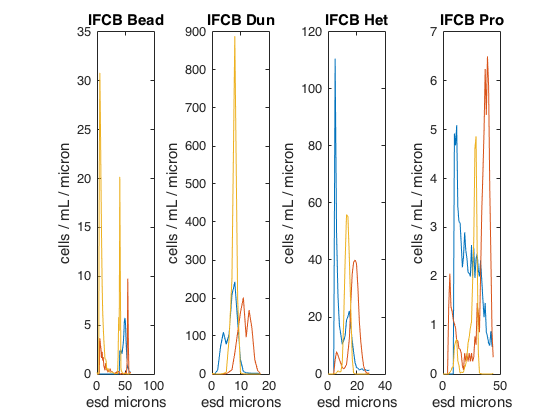

In [1]:
clear all 
close all
clc

%% load the vars for dihm, ifcb, fc, manual, cc. dump each file in common
% load organismDIHM
load organismDIHM_20171229
load fcParticleSizes
load organismIFCB_20180102

%% 1New - DIHM plot all of the DIHM histograms on top of each other

bw = 1;
bins = {[0:bw:60];[0:bw:18];[0:bw:30];[0:bw:45]};
tag = {'DIHM Bead','DIHM Dun','DIHM Het','DIHM Pro'};
mlconvert = 1;

figure(1)
    subplot(1,4,1)

    [stacked_plots(1)] = gizmoParticleSizes_fixYaxis_stacker_average({finalDIHM(1:5).w_ESD},bins{1},tag{1},{finalDIHM(1:5).ans_total_volume_sampled},bw, mlconvert);
        hold on
    
    subplot(1,4,2)
    [stacked_plots(2)] = gizmoParticleSizes_fixYaxis_stacker_average({finalDIHM(6:8).w_ESD},bins{2},tag{2},{finalDIHM(6:8).ans_total_volume_sampled},bw, mlconvert);
    hold on
    
    subplot(1,4,3)
    [stacked_plots(3)] = gizmoParticleSizes_fixYaxis_stacker_average({finalDIHM(9:13).w_ESD},bins{3},tag{3},{finalDIHM(9:13).ans_total_volume_sampled},bw, mlconvert);
    hold on
    
    subplot(1,4,4)
    [stacked_plots(4)] = gizmoParticleSizes_fixYaxis_stacker_average({finalDIHM(14:18).w_ESD},bins{4},tag{4},{finalDIHM(14:18).ans_total_volume_sampled},bw, mlconvert);
    hold on
    
%% 2New - FC plot all of the FC histograms on top of each other needs editing
bw = 1;
bins = {[0:bw:60];[0:bw:18];[0:bw:30];[0:bw:45]};
tag = {'FC Bead','FC Dun','FC Het','FC Pro'};
mlconvert = 0;

    subplot(1,4,1)
    [stacked_plots(5)] = gizmoParticleSizes_fixYaxis_stacker_average({fc(1:15).esd},bins{1},tag{1},{fc(1:15).volPro},bw, mlconvert);

    subplot(1,4,2)
    [stacked_plots(6)] = gizmoParticleSizes_fixYaxis_stacker_average({fc(16:24).esd},bins{2},tag{2},{fc(16:24).volPro},bw, mlconvert);

    subplot(1,4,3)
    [stacked_plots(7)] = gizmoParticleSizes_fixYaxis_stacker_average({fc(25:40).esd},bins{3},tag{3},{fc(25:40).volPro},bw, mlconvert);

    subplot(1,4,4)
    [stacked_plots(8)] = gizmoParticleSizes_fixYaxis_stacker_average({fc(41:56).esd},bins{4},tag{4},{fc(41:56).volPro},bw, mlconvert);


%% 3New - IFCB plot all of the IFCB histograms on top of each other needs editing
bw = 1;
bins = {[0:bw:60];[0:bw:18];[0:bw:30];[0:bw:45]};
tag = {'IFCB Bead','IFCB Dun','IFCB Het','IFCB Pro'};
mlconvert = 0;


    subplot(1,4,1)
        hold on
    [stacked_plots(9)] = gizmoParticleSizes_fixYaxis_stacker_average({ifcb(1:15).esd},bins{1},tag{1},{ifcb(1:15).ml_analyzed},bw, mlconvert);

for i = 16:24;
    % remove black dot on IFCB between 7.8 and 8.1
    deleteIFCB = find([ifcb(i).esd] >=7.5 & [ifcb(i).esd] <= 8.2);
    ifcb(i).esd(deleteIFCB) = [];
end
    subplot(1,4,2)
    [stacked_plots(10)] = gizmoParticleSizes_fixYaxis_stacker_average({ifcb(16:24).esd},bins{2},tag{2},{ifcb(16:24).ml_analyzed},bw, mlconvert);

    subplot(1,4,3)
    [stacked_plots(11)] = gizmoParticleSizes_fixYaxis_stacker_average({ifcb(25:39).esd},bins{3},tag{3},{ifcb(25:39).ml_analyzed},bw, mlconvert);

    subplot(1,4,4)
    [stacked_plots(12)] = gizmoParticleSizes_fixYaxis_stacker_average({ifcb(40:54).esd},bins{4},tag{4},{ifcb(40:54).ml_analyzed},bw, mlconvert);
